In [1]:
!pip install PyPortfolioOpt

In [2]:
!pip install fredapi

In [3]:
!pip install riskfolio-lib

In [1]:
# Installing necessary libraries
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fredapi import Fred
import riskfolio as rp
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

# Setting the visualization style
sns.set()

# Defining the tickers for the stocks. Insurance stocks used are 
''' American International Group, Inc. (AIG):
MetLife, Inc. (MET):
Prudential Financial, Inc. (PRU): 
The Allstate Corporation (ALL): 
The Travelers Companies, Inc. (TRV): '''

insurance_tickers = ["AIG", "MET", "PRU", "ALL", "TRV"]
start_date = "2019-01-01"
end_date = "2024-01-01"


In [2]:
# Fetching the risk-free rate from FRED
api_key = "78b14ec6ba46f484b94db43694468bb1" 
fred = Fred(api_key=api_key)
risk_free_rate_series = fred.get_series("DGS10")  # 10-Year Treasury Rate
risk_free_rate = risk_free_rate_series[-1] / 100  # Converting to decimal
print(f"Risk-Free Rate (latest): {risk_free_rate:.2%}")

# Fetching the stock price data using yahoofinance
stock_data = yf.download(insurance_tickers, start=start_date, end=end_date)["Adj Close"]
stock_data = stock_data.dropna()
print("\nStock Data Summary:")
print(stock_data.describe())


C:\Users\bhoga\AppData\Local\Temp\ipykernel_26608\2921851049.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = risk_free_rate_series[-1] / 100  # Converting to decimal


Risk-Free Rate (latest): 4.23%


[*********************100%***********************]  5 of 5 completed


Stock Data Summary:
Ticker          AIG          ALL          MET          PRU          TRV
count   1258.000000  1258.000000  1258.000000  1258.000000  1258.000000
mean      46.395300   104.744321    49.758135    77.814258   141.480792
std       10.928041    16.288956    12.003382    15.416472    25.389395
min       16.710823    64.940842    19.971470    30.819283    73.875786
25%       38.912791    90.250256    39.045777    68.732096   122.194822
50%       47.970394   105.734692    53.428795    78.793819   144.194611
75%       54.952627   118.973314    59.486726    90.134626   163.125618
max       66.815895   141.402298    72.154045   105.916801   187.869827


Key Metrics:

Mean Price:

TRV has the highest average price of  141.48, which could indicate that this stock is valued higher on absolute terms compared to others.
AIG has the lowest mean of  46.40, probably due to differences in size, market capitalization, or investor perception.

Volatility (Standard Deviation):

TRV and AIG have higher relative price stability (lower std relative to mean).
PRU and ALL show moderate volatility.
Now, use these observations to comment on the risk profile of these stocks.

Price Distribution:

The range from min to max for all stocks indicates substantial historical price variability. This variability was most pronounced in AIG: from a minimum of $16.71 to a high of $66.82.

The interquartile range of 25% to 75% shows that most stocks had their prices cluster around the median, but some stocks show greater spreads, such as AIG and TRV, which indicates outlier events or changes in market sentiment.

In [4]:
# Checking for missing values
missing_data = stock_data.isnull().sum()
print(f"Missing Values:\n{missing_data}")

# Fill missing values (if any)
stock_data = stock_data.fillna(method='ffill')


Missing Values:
Ticker
AIG    0
ALL    0
MET    0
PRU    0
TRV    0
dtype: int64


C:\Users\bhoga\AppData\Local\Temp\ipykernel_26608\463318653.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill')


Missing Values Check
Observation: No missing values are found for any of the selected stocks. That is great, as missing values may later result in inaccuracies in analyses conducted upon these data, such as statistical calculations or modeling.
Good Practice: Even though no missing values were found, the checking of missing values is an essential step in data pre-processing. It ensures that issues like gaps or inconsistencies in data are identified as early as possible.

In [6]:
# Calculating daily and annualized returns
daily_returns = stock_data.pct_change().dropna()
annualized_returns = daily_returns.mean() * 252
annualized_volatility = daily_returns.std() * np.sqrt(252)

# Risk-return DataFrame
risk_return_df = pd.DataFrame({
    "Annualized Return": annualized_returns,
    "Annualized Volatility": annualized_volatility
})
print(risk_return_df)


        Annualized Return  Annualized Volatility
Ticker                                          
AIG              0.218489               0.405354
ALL              0.174784               0.287533
MET              0.189884               0.349120
PRU              0.169290               0.381103
TRV              0.161607               0.284055


Daily Returns
Calculating daily percentage changes is a standard step in time-series analysis for financial data. It allows us to measure short-term performance and extract important measures such as volatility and annualized returns.
Use in Models: These daily returns will form the basis of more complex models such as CAPM, Sharpe ratio, and portfolio optimization.

Annualized Metrics

Annualized Return:
The highest annualized return is AIG 21.85%, so, over the period analyzed, it has been the most rewarding stock.
The lowest annualized return is TRV 16.16%, while lower, still positive.

Annualized Volatility:
AIG also has the highest volatility 40.53%, which agrees with its high return.
TRV has the lowest volatility 28.41%, indicating that among the others, it may be a more stable investment option.

Risk-Return Tradeoff:
Here, the risk and return tradeoff is clearly seen:
AIG gives a high return but at the cost of higher risk.
TRV is conservative and gives a lower return with low risk.

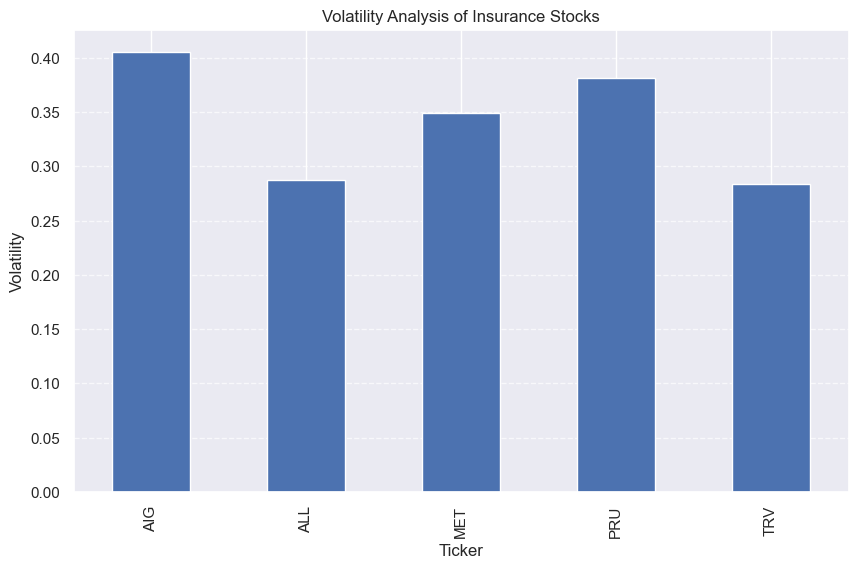

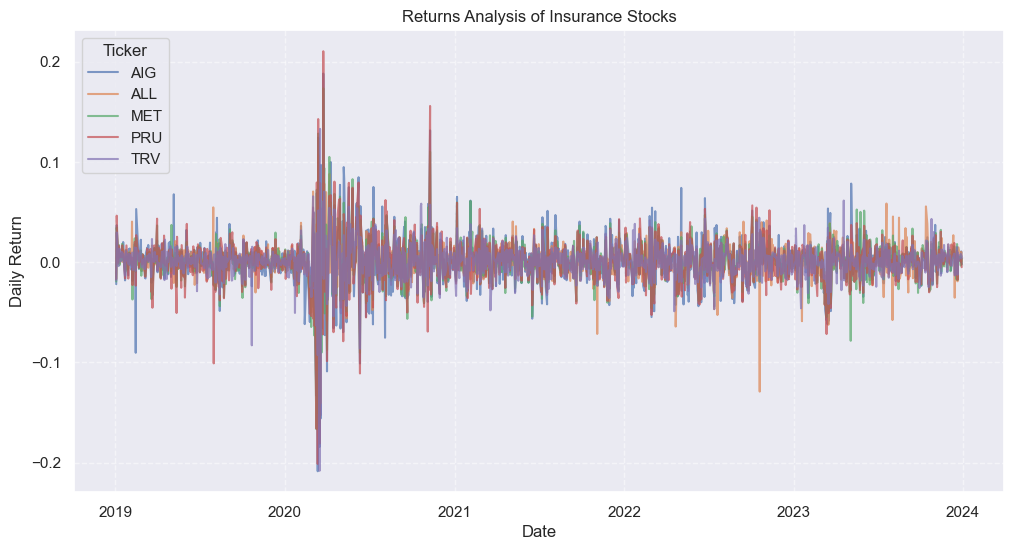

In [14]:
# Calculating annualized volatility
annualized_volatility = daily_returns.std() * np.sqrt(252)

# Volatility Analysis - Bar Chart
plt.figure(figsize=(10, 6))
annualized_volatility.plot(kind="bar")  
plt.title("Volatility Analysis of Insurance Stocks")
plt.xlabel("Ticker")
plt.ylabel("Volatility")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Returns Analysis - Line Chart
plt.figure(figsize=(12, 6))
for ticker in daily_returns.columns:
    plt.plot(daily_returns[ticker], label=ticker, alpha=0.7)
plt.title("Returns Analysis of Insurance Stocks")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend(title="Ticker", loc="upper left")
plt.grid(axis="both", linestyle="--", alpha=0.5)
plt.show()


Volatility Analysis:
AIG and PRU depict the highest volatility among the selected stocks. That means they are sensitive to the market.
TRV and ALL are comparatively less volatile; hence, these stocks can be called more stable and potentially less risky to invest in.
Volatility Insight: While ALL and TRV may appeal more to investors with lower tolerance for risk, AIG and PRU may be attractive to investors desiring potentially higher returns commensurate with higher risk.

Returns Analysis:
The fluctuations in daily returns are really high for the 2020 period and might reflect the effect of the COVID-19 pandemic on the market.
Post-2021, the fluctuations are relatively stable, consistent with broader market recovery trends.
Return Trend Insight: This indicates that large-scale exogenous macroeconomic shocks to the insurance sector's stock performance exist. It also underlines the importance of diversification in reducing risks during crises.

Key Takeaways:
High volatility stocks may give high returns, but they also are associated with higher risk; it seems that one needs to trade off between risk and return. The external shocks on the market, such as the pandemic, create tremendous noise and risk in returns, calling for adaptive portfolio strategies. It follows that the insurance sector may turn out to be dependable for long-term investment stability as such stocks proved resilient after 2021.

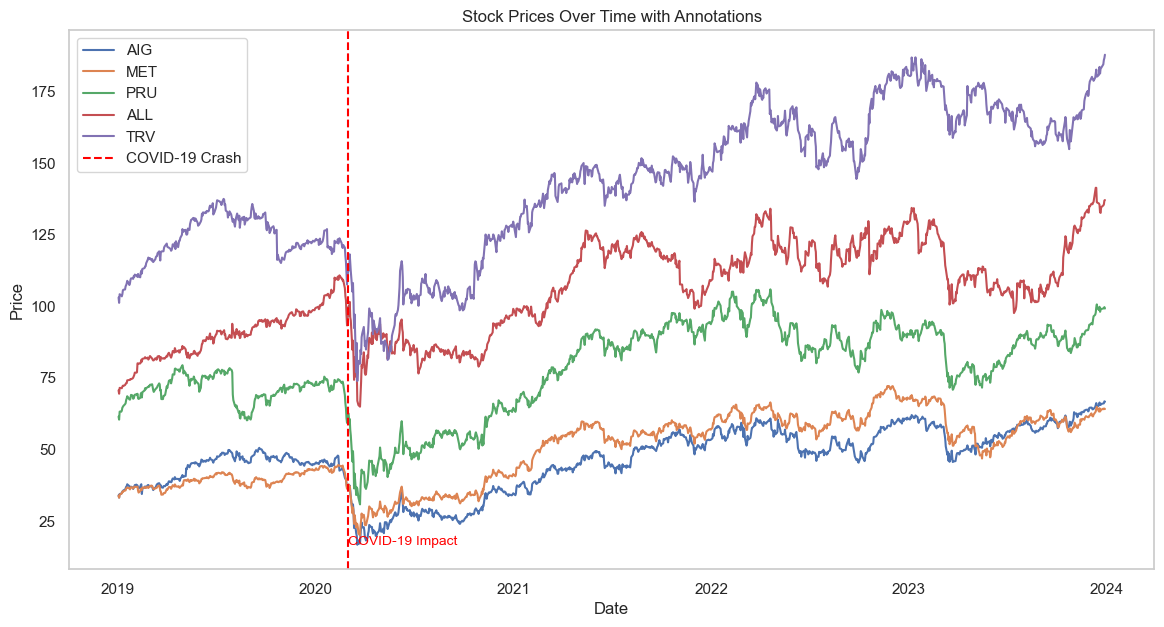

In [55]:
plt.figure(figsize=(14, 7))
for ticker in insurance_tickers:
    plt.plot(stock_data[ticker], label=ticker)

# Annotating COVID-19 Crash
covid_crash_date = pd.to_datetime("2020-03-01")  # Convert to datetime
plt.axvline(x=covid_crash_date, color="red", linestyle="--", label="COVID-19 Crash")
plt.text(covid_crash_date, stock_data.min().min(), "COVID-19 Impact", color="red", fontsize=10)

plt.title("Stock Prices Over Time with Annotations")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()



Stock Prices Over Time (Annotated)
Addition of vertical red line and annotation for the COVID-19 crash provides critical context for the significant dip in 2020.

Insights:
Most stocks did recover steadily after 2020, but TRV showed the strongest and most consistent growth.
It has highlighted the market impact due to the pandemic on this chart.

Lowest Correlation: AIG (('AIG', 'ALL'))


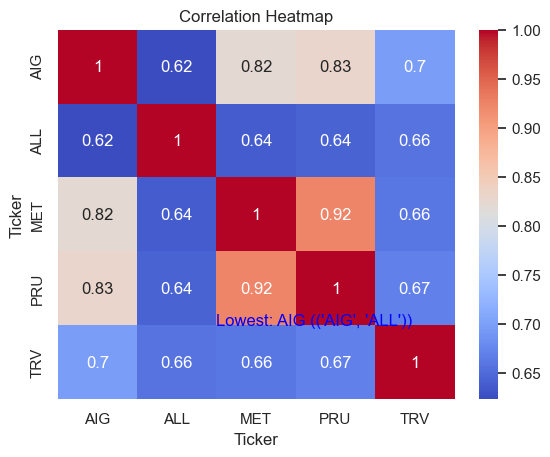

In [58]:
correlation_matrix = daily_returns.corr()

# Highlighting lowest correlations
lowest_corr = correlation_matrix[correlation_matrix != 1].min().idxmin()
lowest_pair = correlation_matrix.stack().idxmin()

print(f"Lowest Correlation: {lowest_corr} ({lowest_pair})")

# Updating the heatmap to annotate the lowest correlation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.text(2, 4, f"Lowest: {lowest_corr} ({lowest_pair})", fontsize=12, color="blue")
plt.show()


Overall Correlation:

This heatmap demonstrates the correlation between the returns of the different insurance stocks.
The majority of stocks show positive correlation, hence these stocks show a general tendency of movement in the same direction but at different strengths.

Strongest Correlation:
PRU-MET has the highest value (0.92) amongst all pairs and is indicative of high comovement. One possible cause of such phenomena is similar market exposure or specific sectoral factors.

Weakest Correlation:
The weakest correlation among all pairs is between AIG and ALL, 0.62. The lower level of correlation reflects that their behavior may differ in response to similar market events and hence can be useful from a diversification perspective.

Diversification Opportunities:
With AIG and ALL having the lowest correlation, a portfolio could reduce its risk including both.
Other moderately correlated pairs like TRV and ALL also show diversification potential at 0.66.

Sectoral Trend:
High correlations among stocks such as PRU, MET, and TRV suggest that these companies may share exposure to similar macroeconomic or sector-specific factors, such as interest rate changes or regulatory updates.

Portfolio Construction:
The heatmap emphasizes how correlation analysis plays an important role in portfolio construction. Stock combinations with low correlation can mitigate the risk of a portfolio while delivering the best possible returns.

In [61]:
print('Correlation matrix:\n',correlation_matrix)

Correlation matrix:
 Ticker       AIG       ALL       MET       PRU       TRV
Ticker                                                  
AIG     1.000000  0.623472  0.822806  0.830470  0.698062
ALL     0.623472  1.000000  0.637884  0.643130  0.657479
MET     0.822806  0.637884  1.000000  0.924430  0.661249
PRU     0.830470  0.643130  0.924430  1.000000  0.669435
TRV     0.698062  0.657479  0.661249  0.669435  1.000000


In [63]:
annualized_covariance_matrix = daily_returns.cov() * 252
print('Covariance matrix:\n',annualized_covariance_matrix)

Covariance matrix:
 Ticker       AIG       ALL       MET       PRU       TRV
Ticker                                                  
AIG     0.164312  0.072667  0.116441  0.128292  0.080377
ALL     0.072667  0.082675  0.064033  0.070474  0.053700
MET     0.116441  0.064033  0.121885  0.122996  0.065576
PRU     0.128292  0.070474  0.122996  0.145239  0.072469
TRV     0.080377  0.053700  0.065576  0.072469  0.080687


[*********************100%***********************]  1 of 1 completed


Correlation of Insurance Stocks with S&P 500:
Ticker
AIG    0.665574
MET    0.733810
PRU    0.744342
ALL    0.617706
TRV    0.611257
Name: ^GSPC, dtype: float64


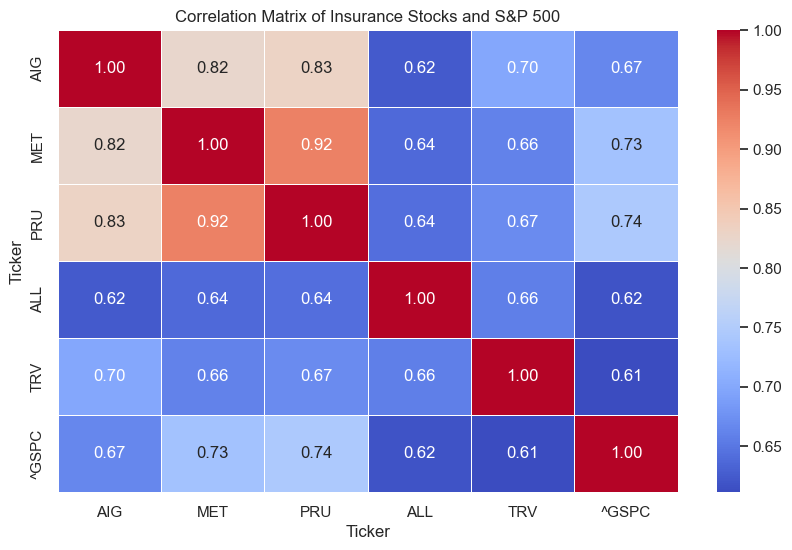

In [65]:

# Fetch market data (S&P 500) and calculate returns
market_ticker='^GSPC'
market_data = yf.download('^GSPC', start=start_date, end=end_date)["Adj Close"]
market_returns = market_data.pct_change().dropna()

# Add market returns to the daily_returns DataFrame
daily_return= daily_returns.copy()
daily_return['^GSPC'] = market_returns

# Calculate the correlation matrix
correlation_matrix = daily_return[insurance_tickers + [market_ticker]].corr()

# Extract correlations of the insurance stocks with the S&P 500
sp500_correlation = correlation_matrix[market_ticker].drop(market_ticker)  # Exclude the S&P 500 itself

# Display the correlations
print("Correlation of Insurance Stocks with S&P 500:")
print(sp500_correlation)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Matrix of Insurance Stocks and S&P 500")
plt.show()


All insurance stocks have a moderate positive correlation with the S&P 500, ranging from 0.61 in the case of TRV to 0.74 in the case of PRU. That is, they generally move in the same direction as the market index but not as strongly as they correlate with each other.

C:\Users\bhoga\anaconda3\Lib\site-packages\matplotlib\text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
C:\Users\bhoga\anaconda3\Lib\site-packages\matplotlib\text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\Users\bhoga\anaconda3\Lib\site-packages\matplotlib\text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
C:\Users\bhoga\anaconda3\Lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yun

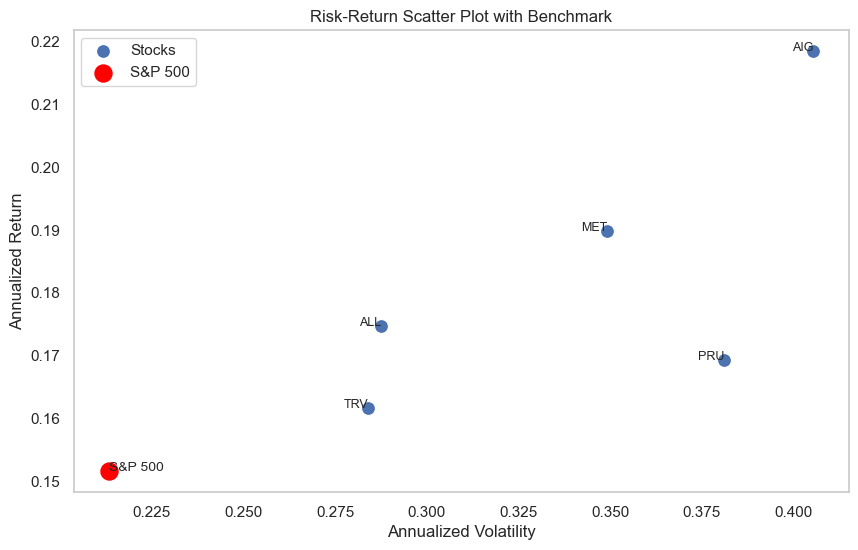

In [68]:
# Scatter plot with benchmark and stock markers

market_annualized_return = market_returns.mean() * 252
market_annualized_volatility = market_returns.std() * np.sqrt(252)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=risk_return_df, x="Annualized Volatility", y="Annualized Return", s=100, label="Stocks")

# Adding labels for each stock
for i in range(len(risk_return_df)):
    plt.text(
        x=risk_return_df["Annualized Volatility"].iloc[i],
        y=risk_return_df["Annualized Return"].iloc[i],
        s=risk_return_df.index[i],  # Assuming the index contains stock tickers
        fontsize=9,
        ha="right"
    )

# Adding the S&P 500 benchmark
plt.scatter(market_annualized_volatility, market_annualized_return, color="red", label="S&P 500", s=150)
plt.text(
    x=market_annualized_volatility,
    y=market_annualized_return,
    s="S&P 500",
    fontsize=10,
    ha="left"
)

# Adding plot details
plt.title("Risk-Return Scatter Plot with Benchmark")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid()
plt.show()


All stocks have returns higher than the S&P 500 but have higher volatility, hence their aggressive risk-return profile.
AIG remains the highest-risk, highest-return stock, while TRV remains the most stable.

AIG presents the highest annualized return of 21.85%, but it also has the highest volatility at 40.53%. 
TRV offers the lowest return of 16.16% with the lowest volatility of 28.41%, hence being the most stable investment. 

The risk-return tradeoff is very apparent: high returns are accompanied by high risks. Investors should balance the two characteristics according to their risk tolerance.

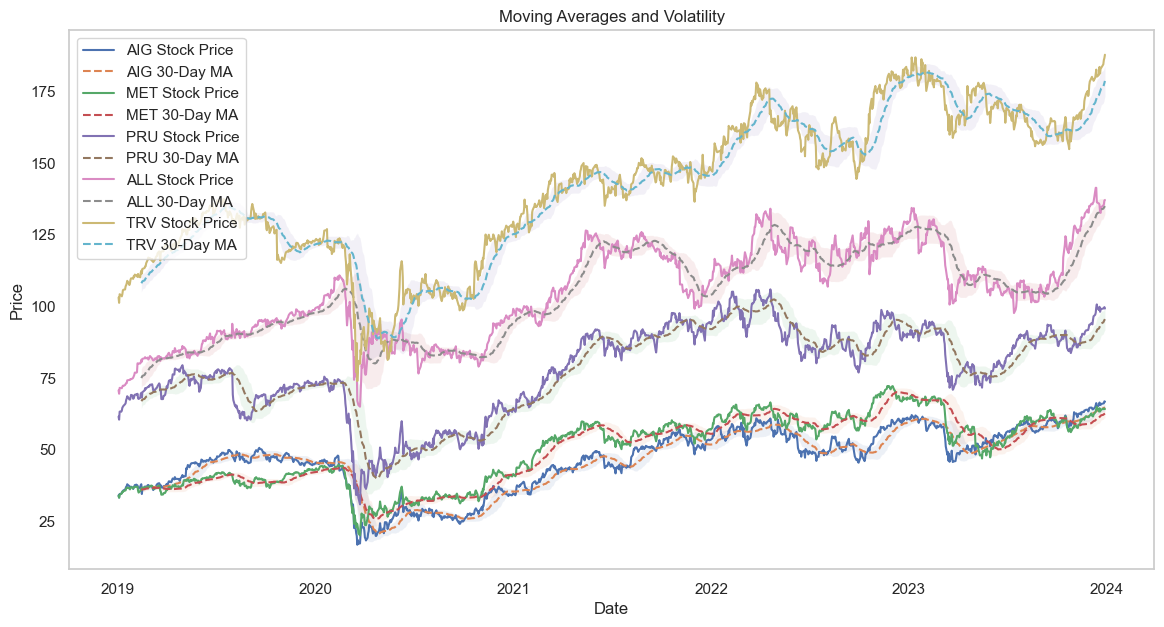

In [71]:
rolling_mean = stock_data.rolling(window=30).mean()
rolling_std = stock_data.rolling(window=30).std()

plt.figure(figsize=(14, 7))
for ticker in insurance_tickers:
    plt.plot(stock_data[ticker], label=f"{ticker} Stock Price")
    plt.plot(rolling_mean[ticker], linestyle="--", label=f"{ticker} 30-Day MA")

# Adding volatility shading
for ticker in insurance_tickers:
    plt.fill_between(stock_data.index,
                     rolling_mean[ticker] - rolling_std[ticker],
                     rolling_mean[ticker] + rolling_std[ticker],
                     alpha=0.1)

plt.title("Moving Averages and Volatility")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


TRV (Yellow): Demonstrates a strong upward movement over the years, aside from minor setbacks during market turmoil-as was the case in early 2020.
AIG and MET: much more volatile, often breaking away from the moving averages.

Stocks like PRU pink exhibit wider deviations of the actual prices against the moving average, which signals higher volatility.
Stocks such as ALL (in blue) are seemingly much less volatile, where the moving average tracks the actual price relatively well.

The moving average lines confirm that all the stocks are susceptible to systematic market shocks, as witnessed during the COVID-19 pandemic in early 2020. This indicates that the insurance sector is highly correlated with broader economic trends.

High Volatility Stocks (e.g., PRU, AIG) might attract risk-tolerant investors who seek higher potential returns in exchange for enduring short-term fluctuations.
Low Volatility Stocks: ALL, TRV could be attractive to the conservative investor seeking stability.



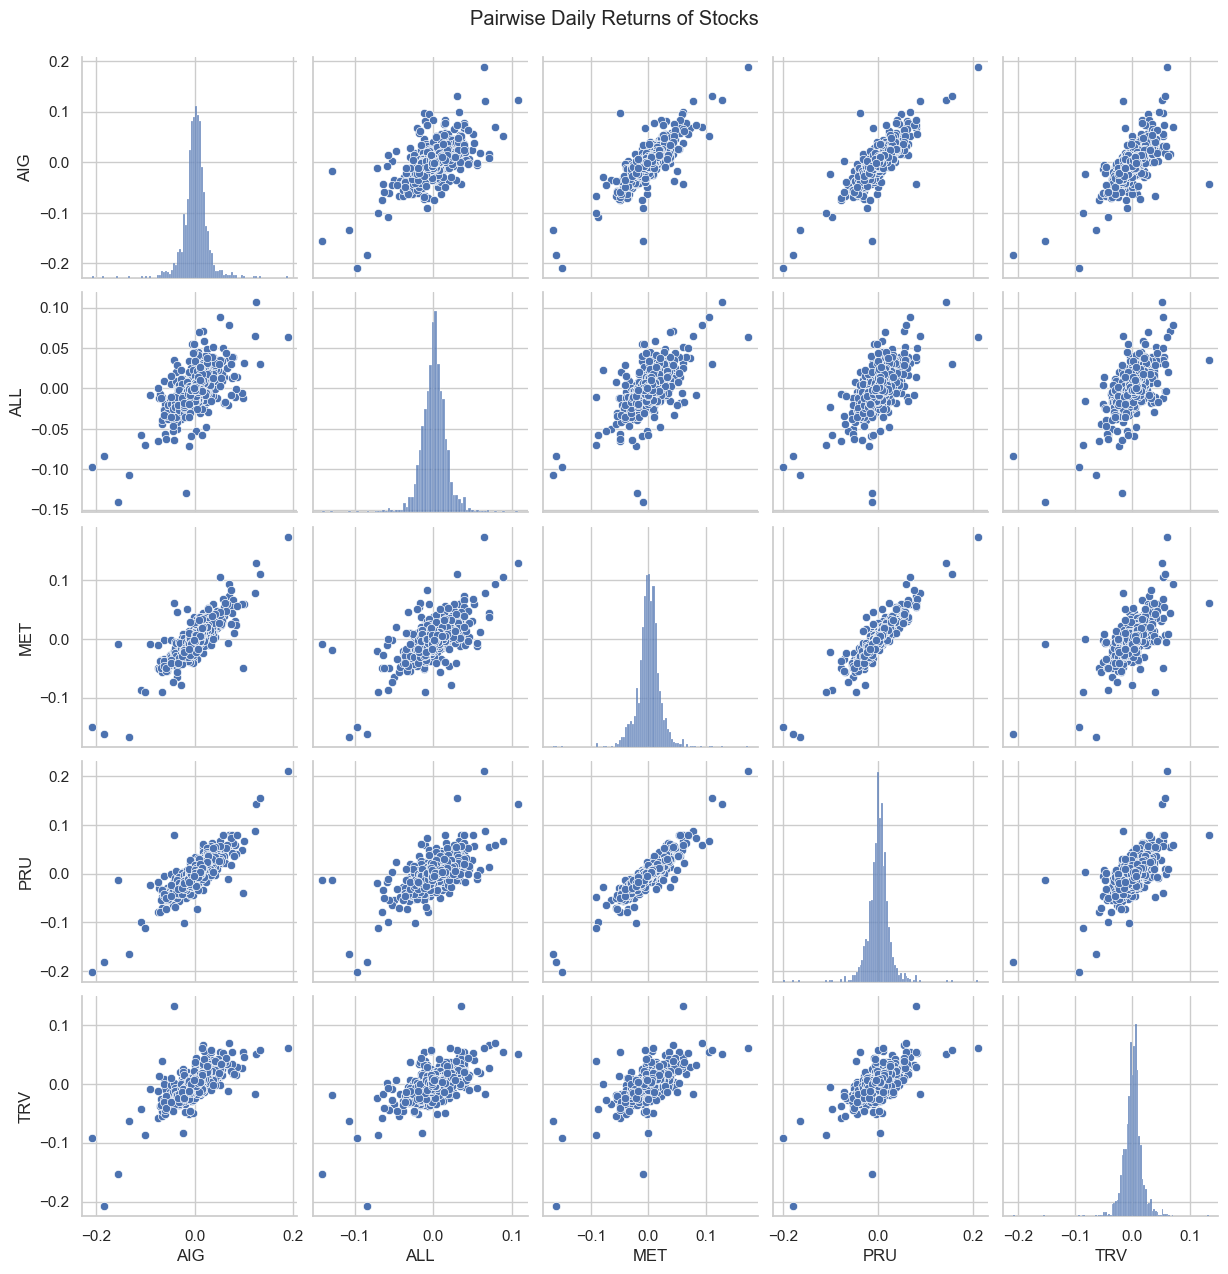

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

#daily_returns is a DataFrame with daily returns of all stocks
sns.set(style="whitegrid")
pair_plot = sns.pairplot(daily_returns, diag_kind="hist")
pair_plot.fig.suptitle("Pairwise Daily Returns of Stocks", y=1.02)  # Adjusting title position
plt.show()


In [75]:
# Calculating Z-scores for returns
z_scores = daily_returns.apply(zscore)
print(z_scores.head())


Ticker                          AIG       ALL       MET       PRU       TRV
Date                                                                       
2019-01-03 00:00:00+00:00 -0.894253 -0.944839 -0.907596 -0.733697 -1.040916
2019-01-04 00:00:00+00:00  1.411814  1.591807  1.535053  1.905074  1.623037
2019-01-07 00:00:00+00:00  0.190292 -0.125157  0.256221 -0.047596 -0.214867
2019-01-08 00:00:00+00:00  0.121159 -0.045012  0.200916  0.217120 -0.253250
2019-01-09 00:00:00+00:00  0.535776  0.383316  0.742114  0.644576  0.362682


In [76]:
# Identify outlier Z-scores (> 3 or < -3)
outliers = z_scores[(z_scores > 3) | (z_scores < -3)].dropna(how="all")
print("Outlier Z-Scores:\n", outliers)


Outlier Z-Scores:
 Ticker                          AIG       ALL       MET       PRU        TRV
Date                                                                        
2019-02-14 00:00:00+00:00 -3.572193       NaN       NaN       NaN        NaN
2019-08-01 00:00:00+00:00       NaN       NaN       NaN -4.231680        NaN
2019-10-22 00:00:00+00:00       NaN       NaN       NaN       NaN  -4.668874
2020-03-02 00:00:00+00:00       NaN  3.855422       NaN       NaN   3.636557
2020-03-05 00:00:00+00:00       NaN       NaN -3.365709       NaN        NaN
2020-03-09 00:00:00+00:00 -5.241774 -5.982079 -7.604035 -6.934321  -3.561073
2020-03-10 00:00:00+00:00       NaN       NaN  3.252673  3.284770        NaN
2020-03-11 00:00:00+00:00       NaN -3.649550       NaN -3.275749  -3.294830
2020-03-12 00:00:00+00:00 -8.200505 -5.378650 -6.864316 -8.409585  -5.209523
2020-03-13 00:00:00+00:00  4.834254  5.873667  5.800414  5.919830        NaN
2020-03-16 00:00:00+00:00 -7.250899 -4.676133 -7.342569 -

Distribution of Z-Scores:
The histogram of the Z scores is strongly peaked around 0 since most returns are close to the mean and this is exactly what should be expected for a normally distributed data set.
There is a gradual tapering on both sides, but we notice some extreme values beyond ±3 confirming the presence of outliers.

Skewness or Heavy Tails:
Any slight asymmetry or heavy tails would then show days of extreme market events that do not lie within the normal distribution.


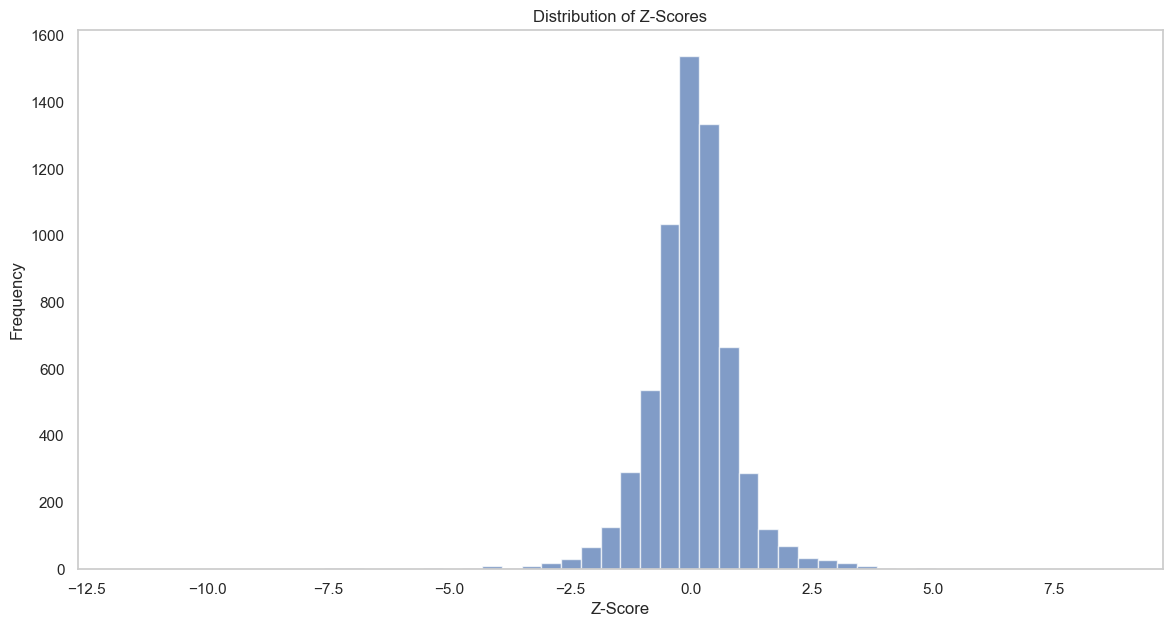

In [80]:
# Plot histogram of Z-scores for all stocks
plt.figure(figsize=(14, 7))
z_scores.stack().hist(bins=50, alpha=0.7)
plt.title("Distribution of Z-Scores")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.grid()
plt.show()

Z-Scores Over Time
The time-series plot reveals bunching of extreme Z-scores around the 2020 COVID-19 market crash.

March 9-13, 2020: All stocks had significant negative Z-scores, as the market fell quite steeply.

24-26 March 2020: Positive Z-scores after the rebound of the market following fiscal and monetary interventions.

Beyond 2020, most periods have Z-scores within ±3, reflecting relative market stability.

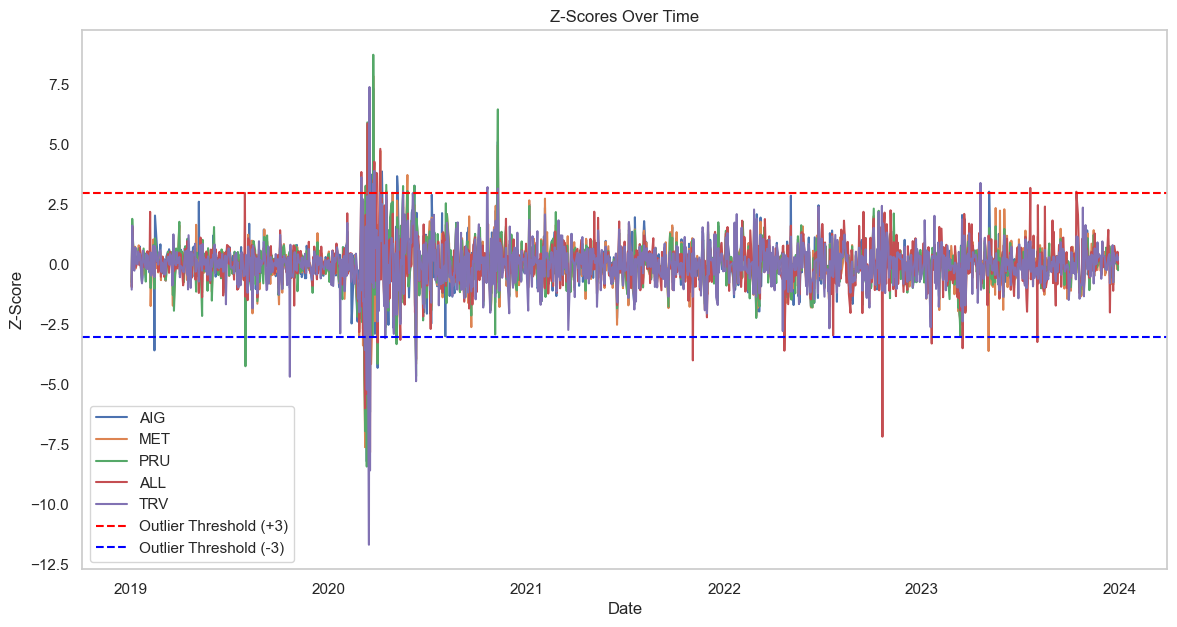

In [83]:
# Plot Z-scores over time for each stock
plt.figure(figsize=(14, 7))
for ticker in insurance_tickers:
    plt.plot(z_scores.index, z_scores[ticker], label=ticker)
plt.axhline(y=3, color="red", linestyle="--", label="Outlier Threshold (+3)")
plt.axhline(y=-3, color="blue", linestyle="--", label="Outlier Threshold (-3)")
plt.title("Z-Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid()
plt.show()

March 2020: Z-scores beyond the threshold of -3 for many stocks were pretty significant, reflecting extreme negative returns due to market panic.

Post-2020, the Z-scores for most stocks are stabilized around the mean, i.e., 0, within the threshold limits.
This would indicate that the market conditions normalized after the initial shock of the pandemic.

ALL and TRV: show less extremity in dispersion, relatively stable compared with their peers.

AIG and PRU exhibit higher Z-score volatility because they are responsive to market happenings.

In [85]:
import statsmodels.api as sm

# Calculating excess returns 
excess_market_returns = market_returns - risk_free_rate
betas = {}

for ticker in insurance_tickers:
    # Align indices and calculate excess stock returns
    aligned_data = pd.concat([daily_returns[ticker], excess_market_returns], axis=1, join="inner").dropna()
    stock_excess_returns = aligned_data.iloc[:, 0]
    market_excess_returns = aligned_data.iloc[:, 1]

    # Prepare X (independent variable) and y (dependent variable)
    X = sm.add_constant(market_excess_returns)  # Add constant for intercept
    y = stock_excess_returns

    # Perform OLS regression
    capm_model = sm.OLS(y, X)
    capm_results = capm_model.fit()

    # Extract beta and alpha
    alpha = capm_results.params['const']
    beta = capm_results.params[market_excess_returns.name]
    betas[ticker] = {"Alpha": alpha, "Beta": beta}

    # Print summary for each stock
    print(f"\nCAPM Results for {ticker}:")
    print(capm_results.summary())

# Display betas
print("\nBetas for All Stocks:")
for ticker, values in betas.items():
    print(f"{ticker}: Beta = {values['Beta']:.4f}, Alpha = {values['Alpha']:.4f}")



CAPM Results for AIG:
                            OLS Regression Results                            
Dep. Variable:                    AIG   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     998.1
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          1.14e-161
Time:                        10:10:27   Log-Likelihood:                 3195.0
No. Observations:                1257   AIC:                            -6386.
Df Residuals:                    1255   BIC:                            -6376.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0531      0.

Betas:
PRU has the highest Beta of 1.33, indicating it is more volatile than the market. For every 1% change in the market, PRU moves by 1.33%
TRV has the lowest Beta of 0.81, meaning it is less volatile and more defensive.

Implication: 
High Beta stocks like PRU may give high returns in a rising market but can be riskier during downswing.

Alphas:
Again, PRU has the highest Alpha of 0.0564, showing that it has outperformed the predictions by the CAPM.
TRV and ALL have lower Alphas (0.0348 and 0.0356, respectively), indicating limited performance above expectations.

Goodness-of-Fit:
R-squared values range from 0.37 (TRV) to 0.55 (PRU), indicating moderate explanatory power of CAPM for these stocks.
Insight: CAPM explains 55% of the variance in PRU returns but only 37% for TRV, suggesting additional factors may influence TRV.

Significance:
All coefficients (Alpha, Beta) have p-values < 0.05, indicating statistical significance.
The models are well fitted, as indicated by high F-statistics and low standard errors.

Implications for Decision-Making
Defensive vs. Aggressive Stocks:
TRV and ALL are defensive, with lower Betas, hence ideal for investors who are risk-averse.
AIG, MET, and PRU are more aggressive, with higher Betas, hence appealing to investors who are risk-tolerant.

Outperformance:
Stocks with high Alphas, such as PRU, can outperform and yield better returns than the market would expect.
Portfolio Implications:
Diversification through balancing high Beta stocks with low Beta stocks can help control the overall portfolio risk.


In [87]:
# Extract only Beta values from the betas dictionary
beta_values = {ticker: betas[ticker]["Beta"] for ticker in betas}

# Convert beta values to a Pandas Series for compatibility
beta_series = pd.Series(beta_values)

# Calculate Sharpe Ratios
sharpe_ratios = (annualized_returns - risk_free_rate) / annualized_volatility

# Calculate Treynor Ratios
treynor_ratios = annualized_returns / beta_series

# Display results
print("Sharpe Ratios:")
print(sharpe_ratios)

print("\nTreynor Ratios:")
print(treynor_ratios)


Sharpe Ratios:
Ticker
AIG    0.435642
ALL    0.462150
MET    0.423877
PRU    0.334266
TRV    0.421422
dtype: float64

Treynor Ratios:
AIG    0.172685
ALL    0.209839
MET    0.158047
PRU    0.127254
TRV    0.198468
dtype: float64


Sharpe Ratios
Definition: The Sharpe Ratio measures the risk-adjusted return and indicates how much excess return a stock generates above the risk-free rate per unit of volatility.

Observations:
ALL has the highest Sharpe Ratio, 0.46, indicating the best risk-adjusted returns.
PRU has the lowest Sharpe Ratio, 0.33, which implies relatively weaker risk-adjusted performance.
Implication: Investors looking for optimal risk-adjusted performance may prefer ALL over PRU.

Treynor Ratios
Definition: The Treynor Ratio gives the risk-adjusted return relative to market risk (Beta) and tells an investor how much excess return a stock is providing per unit of systematic risk.

Observations:
ALL again leads with the highest Treynor Ratio of 0.21, reflecting strong performance relative to its market risk.
PRU has the lowest Treynor Ratio of 0.13, consistent with the lower Sharpe Ratio and higher Beta.
Implication: ALL offers the best reward for market risk and therefore is appealing for systematic risk management

Risk-Return Tradeoffs
Comparison:
Both measures identify ALL as one of the top performers in terms of risk-adjusted returns, while its absolute returns are substantially lower than those of much more volatile stocks such as PRU or AIG.
TRV has a relatively balanced Sharpe and Treynor Ratios, indicating a stable profile with moderate compensation for risk.

Portfolio Implications:
High Sharpe and Treynor Ratios favor ALL and TRV for conservative investors.
Lower ratios for PRU suggest that it may appeal to risk-tolerant investors seeking higher absolute returns.


In [89]:
market_return=market_returns.mean() * 252
market_return[0]

C:\Users\bhoga\AppData\Local\Temp\ipykernel_17228\1216195998.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_return[0]


0.15158419146035995

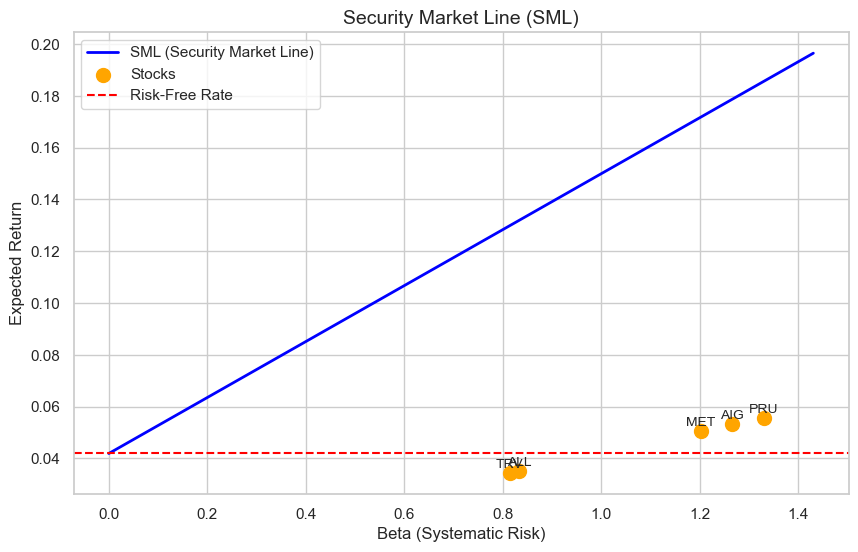

In [99]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Data from the CAPM analysis
beta_values = [1.2652, 1.2014, 1.3303, 0.8329, 0.8143]  # Beta values for AIG, MET, PRU, ALL, TRV
actual_returns = [0.0531, 0.0504, 0.0556, 0.0351, 0.0343]  # Alpha values as actual returns for AIG, MET, PRU, ALL, TRV
stock_names = ["AIG", "MET", "PRU", "ALL", "TRV"]

# Risk-free rate and market return as per CAPM assumptions
risk_free_rate = 0.0419  # Risk-free rate (adjusted for context)
market_return = 0.15  # Estimated market return

# Calculating the expected returns using CAPM formula: E(R) = Rf + Beta * (Rm - Rf)
expected_returns = [risk_free_rate + beta * (market_return - risk_free_rate) for beta in beta_values]

# Defining the SML line
sml_x = np.linspace(0, max(beta_values) + 0.1, 100)
sml_y = risk_free_rate + sml_x * (market_return - risk_free_rate)

# Plotting the SML
plt.figure(figsize=(10, 6))
plt.plot(sml_x, sml_y, label="SML (Security Market Line)", color="blue", linewidth=2)

# Plotting actual stock returns
plt.scatter(beta_values, actual_returns, color="orange", label="Stocks", s=100)
for i, (beta, actual_return) in enumerate(zip(beta_values, actual_returns)):
    plt.text(beta, actual_return + 0.002, stock_names[i], fontsize=10, ha="center")

# Adding the risk-free rate line for context
plt.axhline(risk_free_rate, color="red", linestyle="--", label="Risk-Free Rate")

# Adding labels, title, and legend
plt.title("Security Market Line (SML)", fontsize=14)
plt.xlabel("Beta (Systematic Risk)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


SML Line:

The blue line is the theoretical SML calculated via the CAPM formula. This line plots the relationship between risk (beta) and expected return in an efficient market.
Risk-Free Rate:

The red dotted line reflects the risk-free rate, approximately 4%. Any asset or portfolio return below this threshold would not justify the associated risk.

Stock Points:

Each orange dot represents a stock. The location of the dot on the graph indicates the beta of the stock and its expected return.
Observations:

Stocks that are above the SML are undervalued and yield better returns for the amount of risk.
Stocks that are below the SML are overvalued and yield too little return for the risk.

Examples:

TRV and ALL are below the SML and may be overvalued.
AIG, MET, and PRU are closer to, or slightly above, the SML, which shows alignment or slight undervaluation in respect to their risk level.

Decomposing AIG...


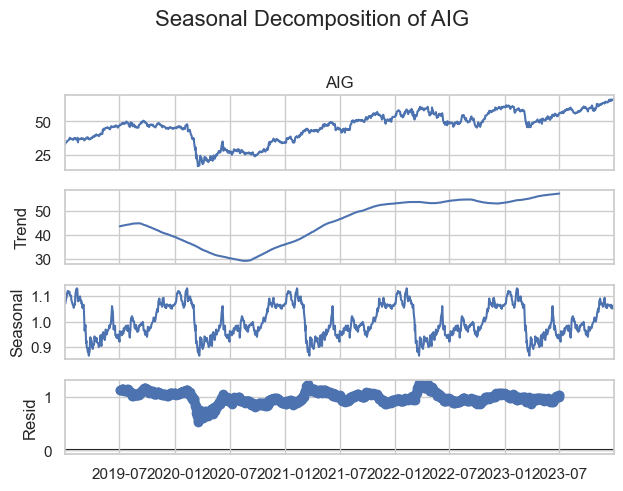

Decomposing MET...


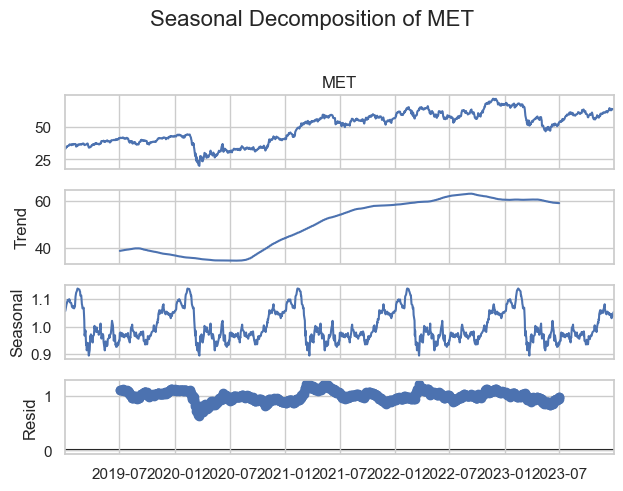

Decomposing PRU...


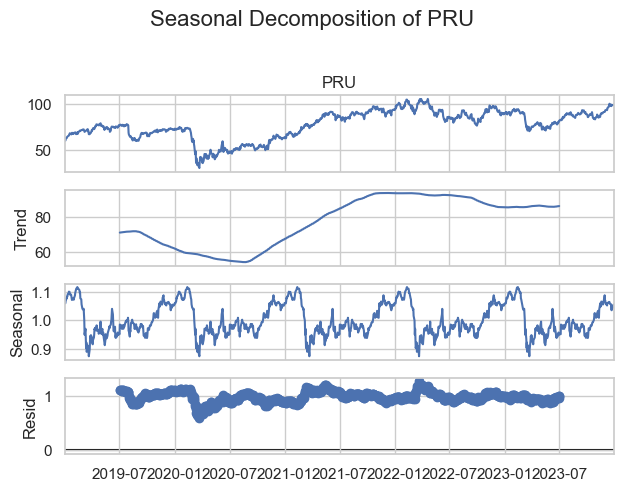

Decomposing ALL...


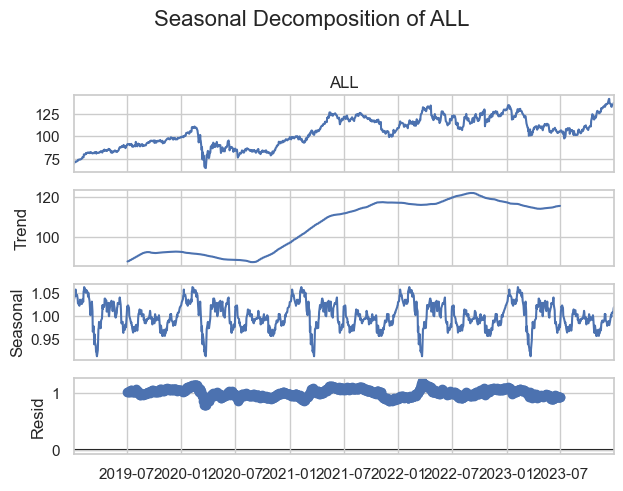

Decomposing TRV...


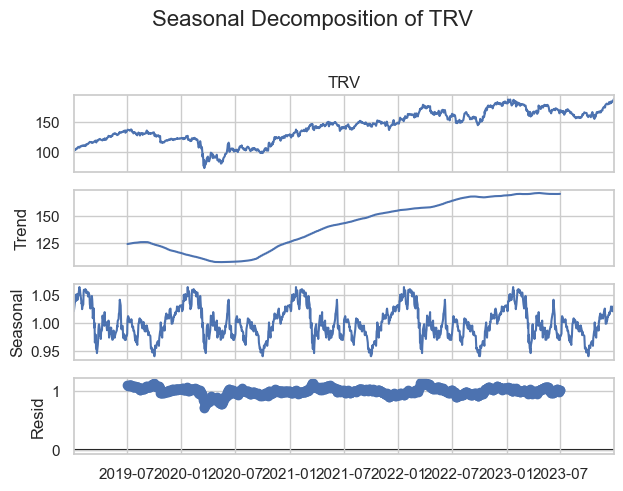

In [159]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition for each ticker
for ticker in insurance_tickers:
    print(f"Decomposing {ticker}...")
    series = stock_data[ticker].dropna()
    
    # Decompose the series
    decomposition = seasonal_decompose(series, model='multiplicative', period=252)  # Assuming daily data with ~252 trading days in a year
    fig = decomposition.plot()
    
    # Adjust the title and spacing
    fig.suptitle(f"Seasonal Decomposition of {ticker}", fontsize=16, y=1.02)  # Adjust y for title position
    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()


Trend Component:
The trend lines across all stocks reflect the general direction of stock prices over time.
In all stocks, the COVID-19 pandemic of early 2020 is marked by a significant fall in prices, followed by recovery trends.
The trends for AIG, MET, PRU, and TRV indicate steady recoveries, some with fluctuations, while ALL seems to be more stable with upward movements consistently in the post-2020 period.

Seasonal Component:
The seasonality plots indicate periodic patterns in the stock prices.
All the stocks have a clear seasonal fluctuation, which likely reflects quarterly or yearly business cycles affecting insurance firms.
These periodic variations suggest that external factors like regulatory requirements, financial disclosures, or macroeconomic indicators might influence insurance stock prices in a predictable manner.

Residual Component:
The residuals represent the irregular component, which includes random noise and unexpected events not captured by the trend or seasonal components.
The residuals appear stationary for most stocks, with higher volatility around early 2020 (COVID-19 onset), indicating unpredictable market behavior during the crisis.
Post-crisis, residuals return to more stable patterns, reflecting reduced noise and fewer external shocks.

AIG:Significant recovery trend post-2020, but there are clear seasonal dips, and strong residual fluctuation during the crisis.

MET:A smooth trend recovery with very strong seasonality. Residuals show high noisiness during crises before they finally stabilize.

PRU:Sharp recovery in the trend joined by the sharp seasonal component of this time series. The noisiness of residuals decreases over time.

ALL:The least volatile stock in terms of its trend, indicating a low propensity to financial crises.Seasonal patterns are subdued in comparison with others, reflecting stability in its operations.

TRV:The graph for TRV is similar to PRU with strong seasonal cycles and a recovering trend. Residual noise spikes are visible around 2020.


AIG:


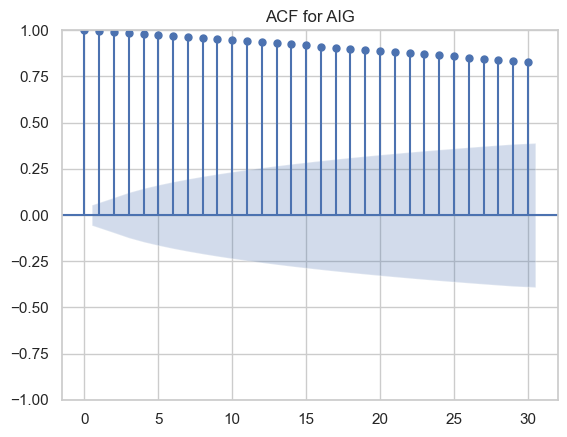

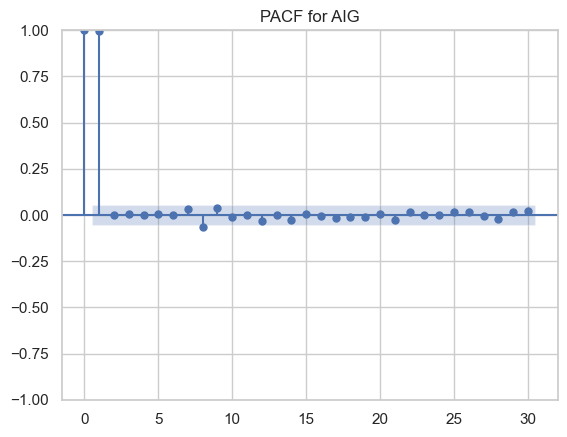


MET:


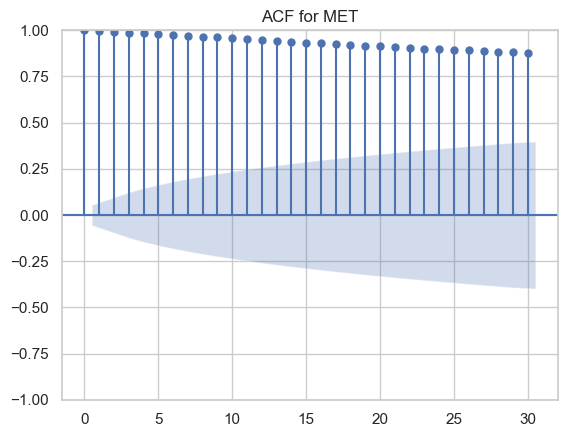

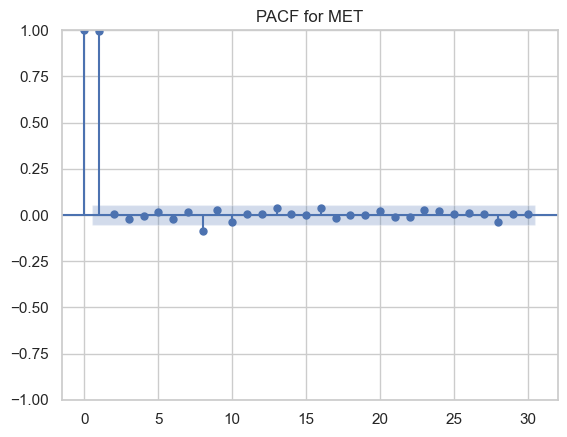


PRU:


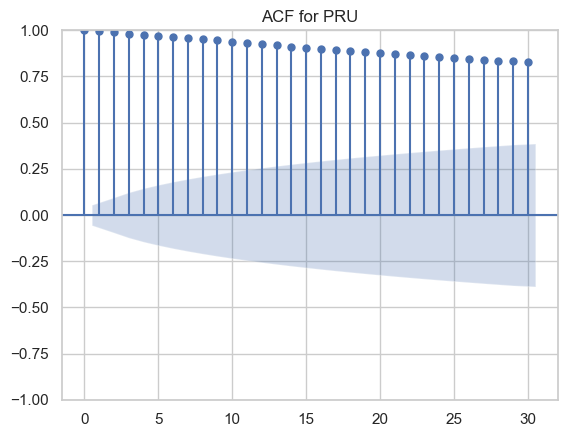

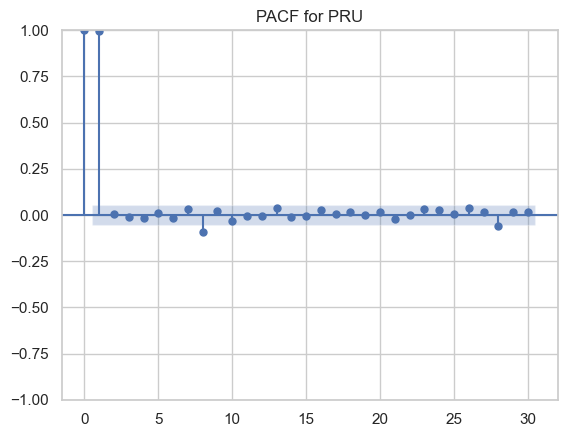


ALL:


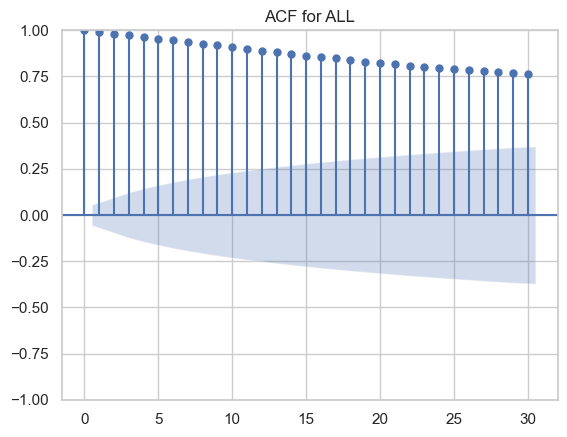

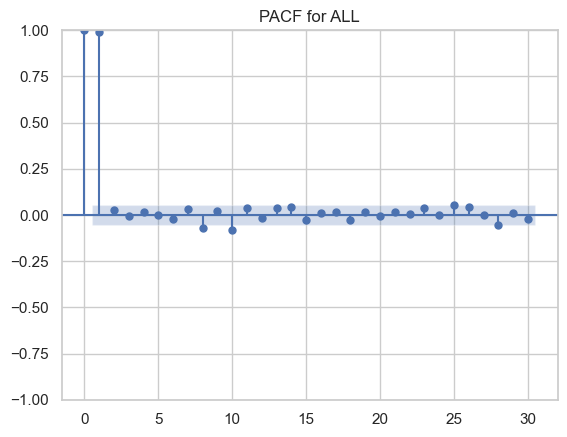


TRV:


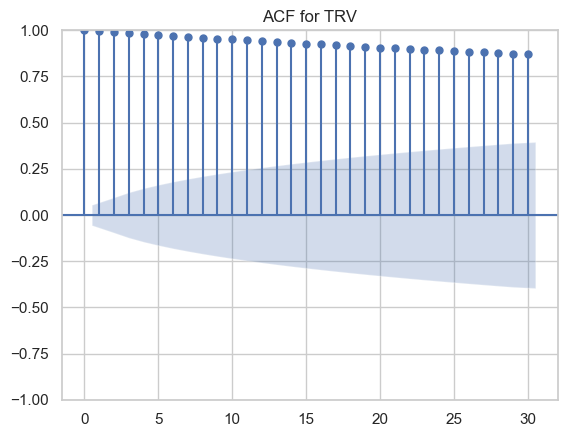

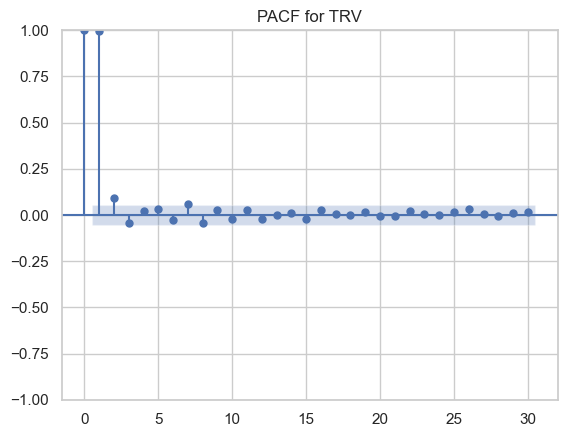

In [153]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check stationarity and plot ACF/PACF
for ticker in insurance_tickers:
    print(f"\n{ticker}:")
    plot_acf(stock_data[ticker].dropna(), lags=30)
    plt.title(f"ACF for {ticker}")
    plt.show()
    
    plot_pacf(stock_data[ticker].dropna(), lags=30)
    plt.title(f"PACF for {ticker}")
    plt.show()


AIG:
ACF: The series shows a slow and steady decay, which is indicative of a non-stationary time series.
PACF: The first lag is significant, with a sharp drop-off, indicating an AR(1) process.


MET:
ACF: Similar to AIG, the ACF decays gradually, confirming non-stationarity.
PACF: The first lag is significant, with minimal spikes afterward, suggesting an AR(1) process.


PRU:
ACF: Slow decay, which indicates that the series is not stationary.
PACF: The first lag has a sharp spike and then becomes insignificant for higher lags, which indicates AR(1).


ALL:
ACF: The decay is consistent with a non-stationary series.
PACF: The first lag is significant, with a drop-off thereafter. Indicates AR(1) behavior.


TRV:
ACF: Like the other stocks, the slow decay confirms non-stationarity.
PACF: A sharp spike at lag 1 suggests an AR(1) component.




Processing AIG...
The data is not stationary (p-value >= 0.05). Applying differencing...


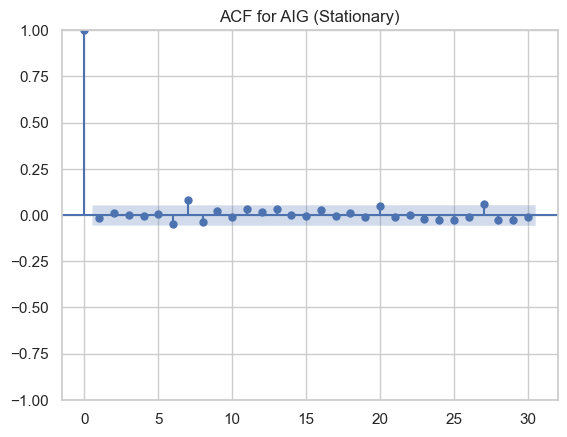

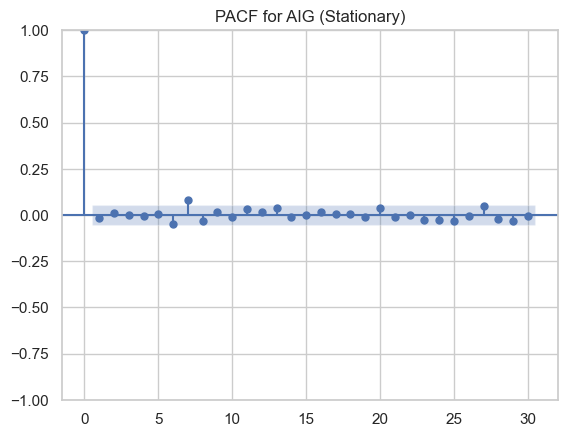


Processing MET...
The data is not stationary (p-value >= 0.05). Applying differencing...


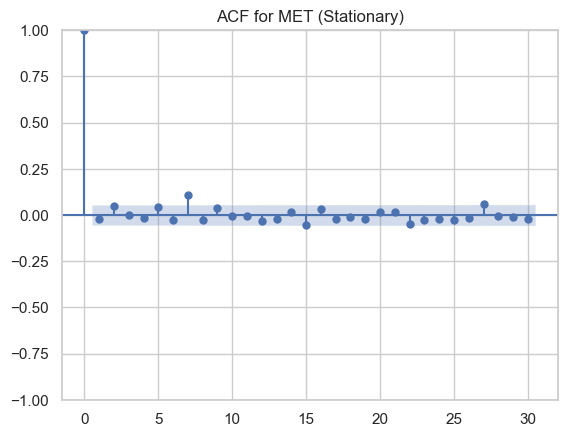

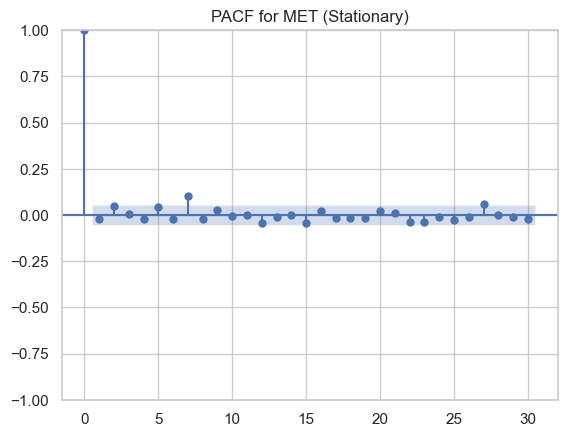


Processing PRU...
The data is not stationary (p-value >= 0.05). Applying differencing...


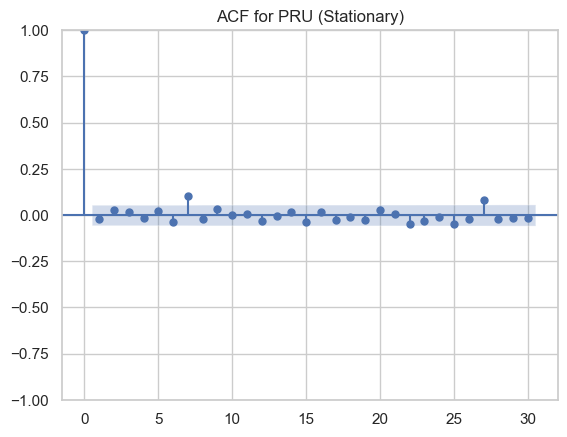

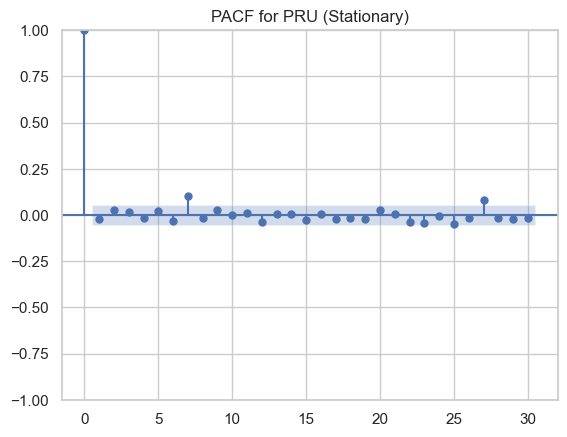


Processing ALL...
The data is not stationary (p-value >= 0.05). Applying differencing...


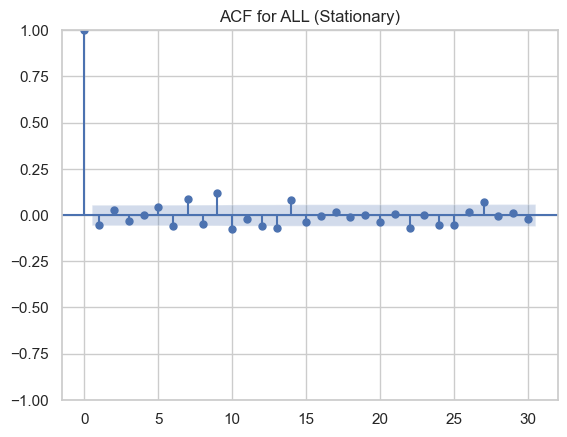

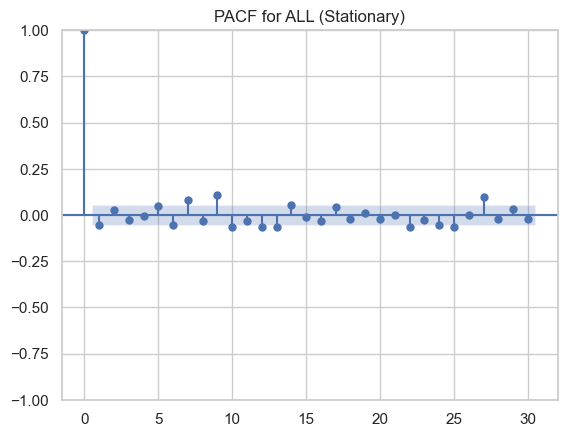


Processing TRV...
The data is not stationary (p-value >= 0.05). Applying differencing...


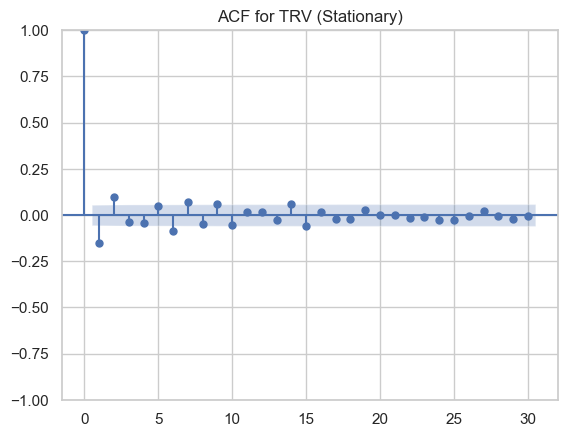

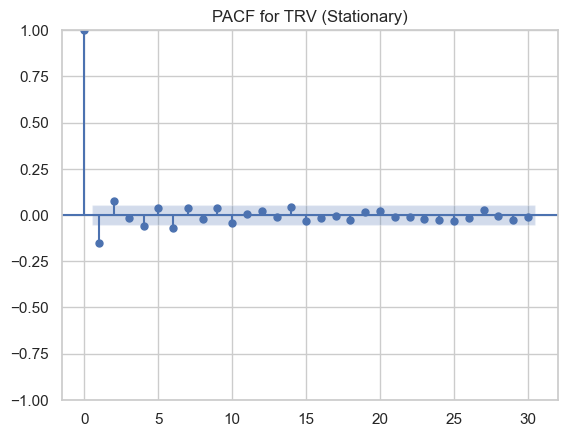

In [161]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define a function to check stationarity and apply differencing
def make_stationary(data):
    # Perform the Augmented Dickey-Fuller test
    adf_test = adfuller(data)
    if adf_test[1] < 0.05:
        print("The data is already stationary (p-value < 0.05).")
        return data
    else:
        print("The data is not stationary (p-value >= 0.05). Applying differencing...")
        return data.diff().dropna()

# Check stationarity, make stationary, and plot ACF/PACF
for ticker in insurance_tickers:
    print(f"\nProcessing {ticker}...")
    series = stock_data[ticker].dropna()
    
    # Make the data stationary
    stationary_series = make_stationary(series)
    
    # Plot ACF and PACF for stationary data
    plot_acf(stationary_series, lags=30)
    plt.title(f"ACF for {ticker} (Stationary)")
    plt.show()
    
    plot_pacf(stationary_series, lags=30)
    plt.title(f"PACF for {ticker} (Stationary)")
    plt.show()


AIG:
ACF: Dimishing autocorrelations to values close to zero after a lag of 1 demonstrates stationarity.
PACF: The sharp spike at the 1st lag, followed by lags mostly within a CI (not significant), indicates the potential for an AR(1) process.

MET
ACF: A lot was seen decaying to close to zero after the 1st lag, ensuring effectiveness within the differencing step
PACF: Spike at lag 1 dominating, other values insignificant which suggest AR(1) processes

PRU:
ACF: All show similar exponential decay, confirming that no residual autocorrelation is present in the data. PACF: Significant at lag 1, with a sharp cutoff, indicating that an AR(1) component is appropriate. 

ALL: 
ACF: The autocorrelation function has a sharp drop-off after lag 1, ensuring that no persistence or trend remains in the series. PACF: Consistent with an AR(1) process; the first lag is significant, with others diminishing quickly.

TRV:
ACF: Sharp decline in values after lag 1 confirms no long-term dependencies. PACF: Single significant spike at lag 1-this would suggest an AR(1) process.

Fitting ARIMA(6,1,6) for AIG...


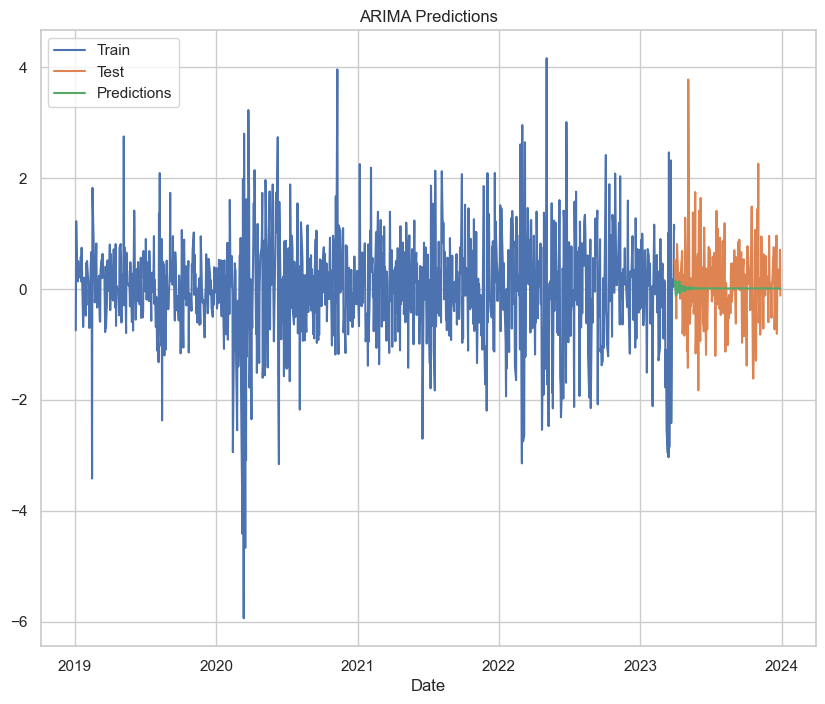

parameters for AIG      mae_ma    mse_ma   rmse_ma
0  0.555497  0.548529  0.740627


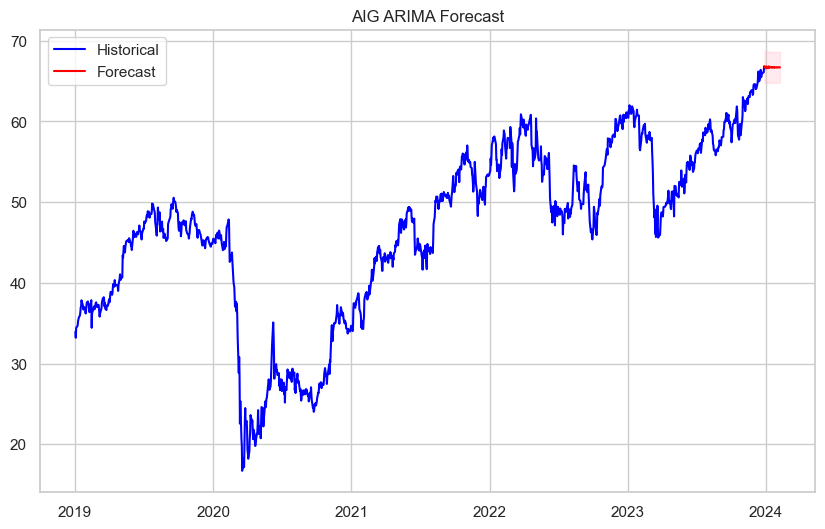

Fitting ARIMA(7,1,7) for MET...


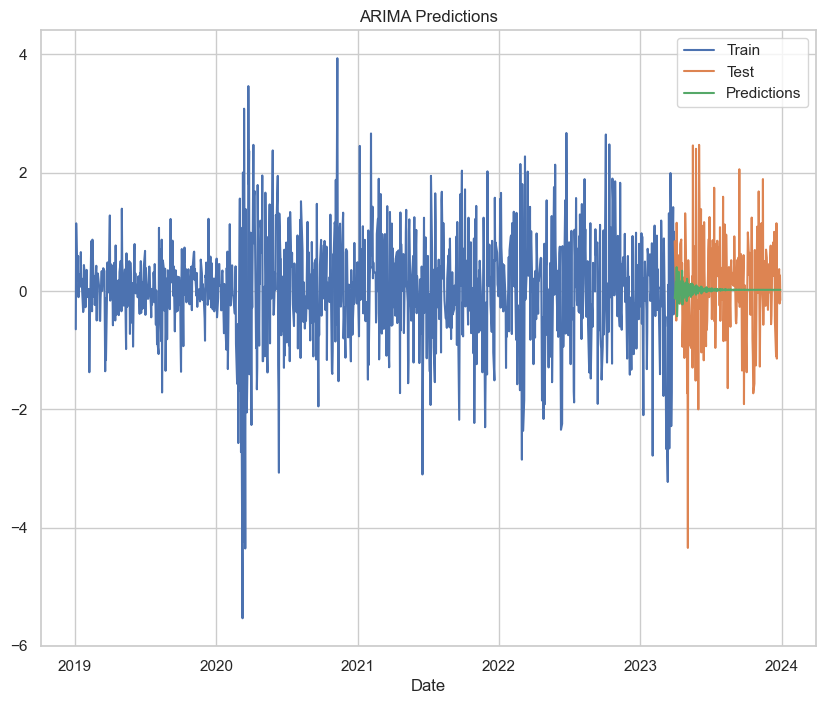

parameters for MET      mae_ma    mse_ma   rmse_ma
0  0.665423  0.790795  0.889267


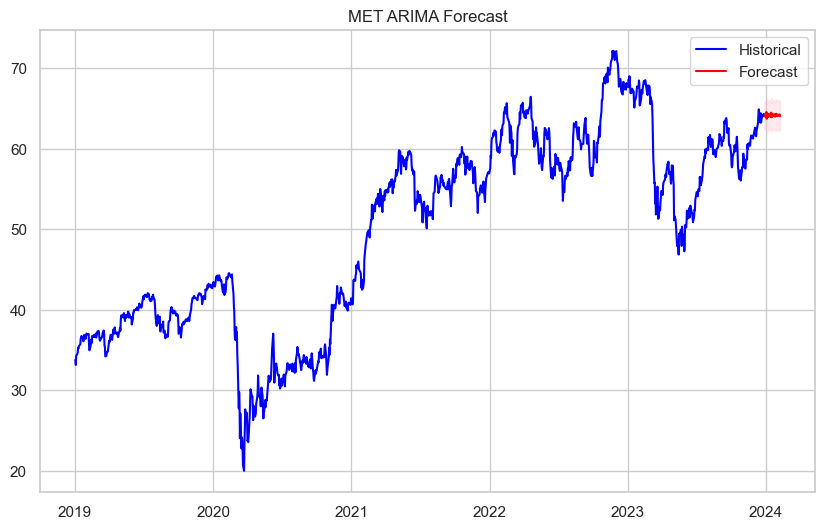

Fitting ARIMA(7,1,7) for PRU...


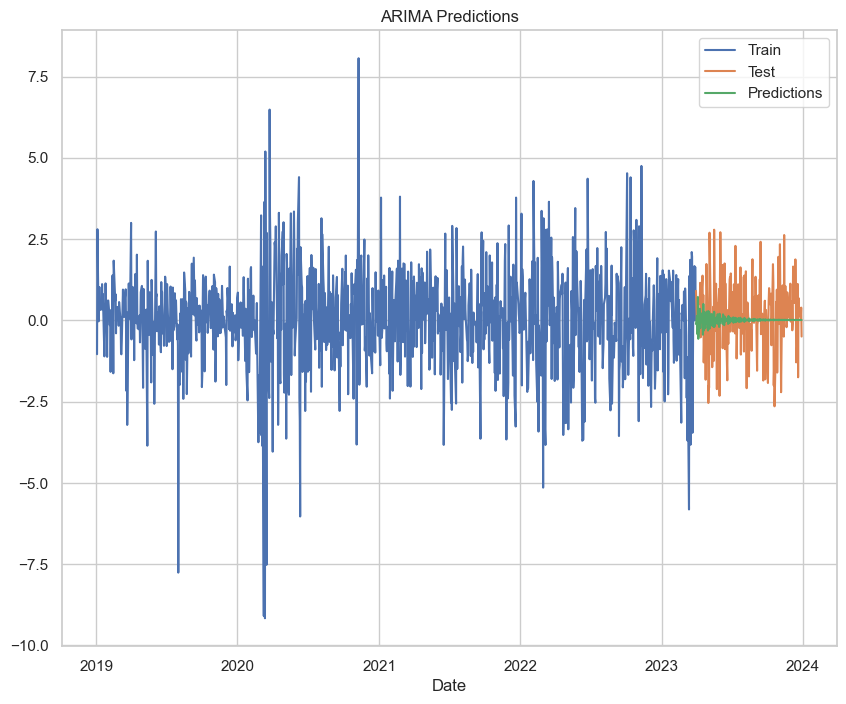

parameters for PRU      mae_ma    mse_ma   rmse_ma
0  0.858577  1.237381  1.112376


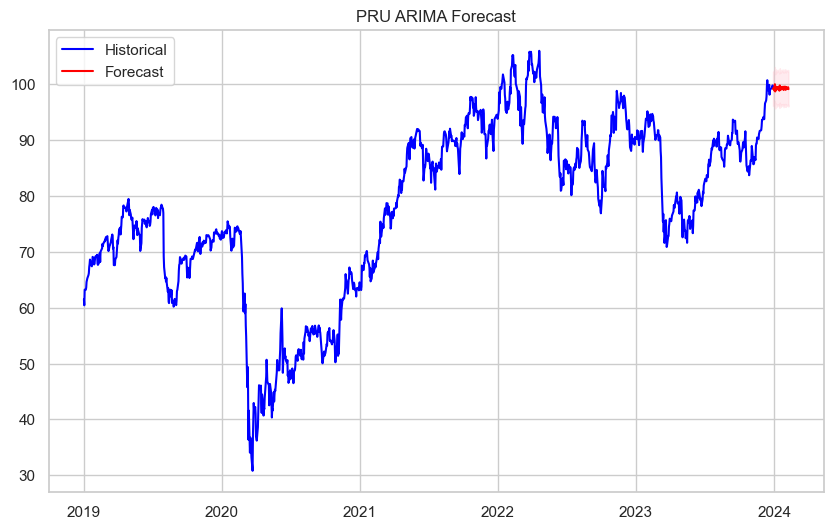

Fitting ARIMA(6,1,6) for ALL...


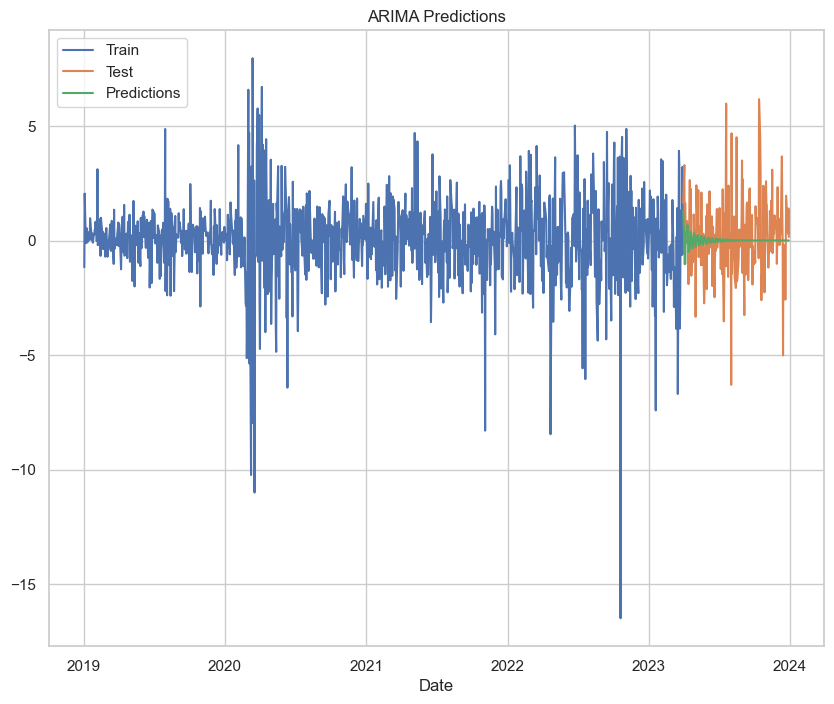

parameters for ALL      mae_ma    mse_ma   rmse_ma
0  1.286115  3.047718  1.745772


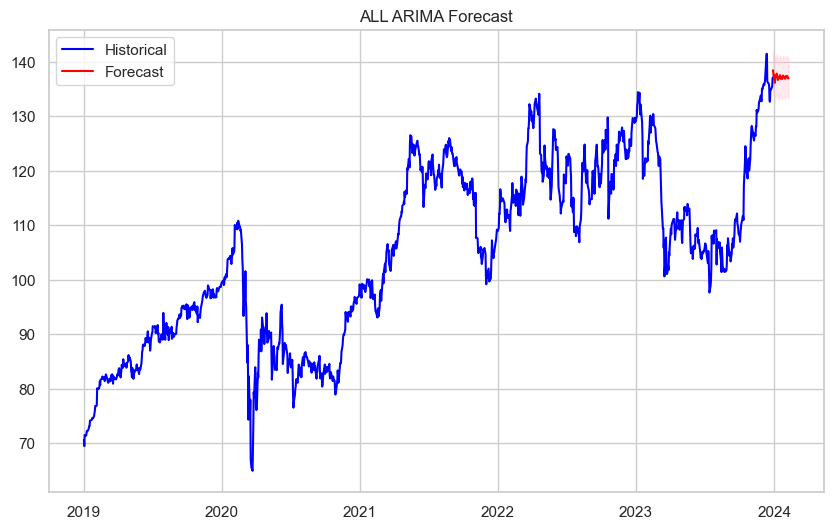

Fitting ARIMA(1,1,1) for TRV...


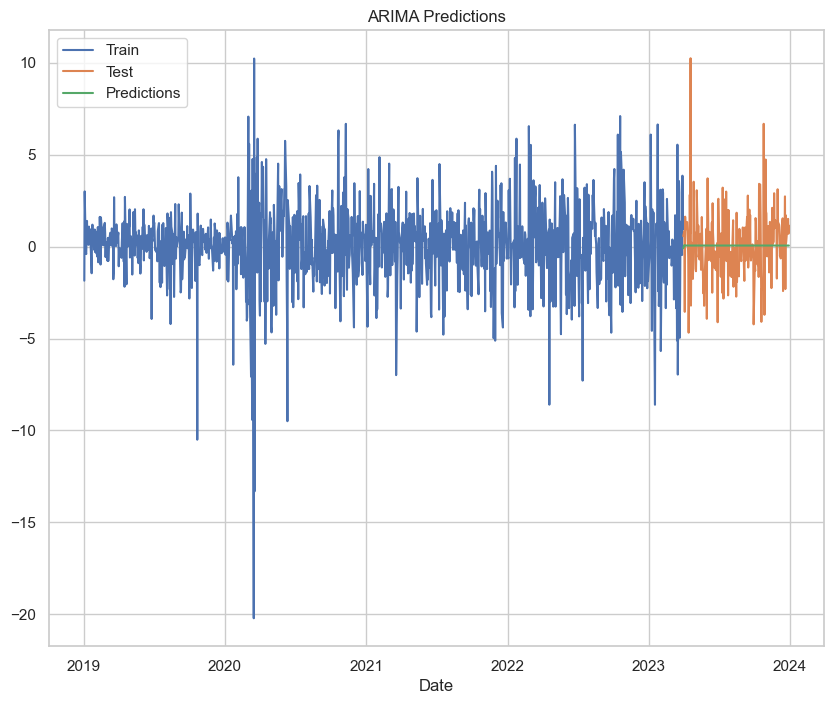

parameters for TRV      mae_ma    mse_ma  rmse_ma
0  1.436381  3.717725  1.92814


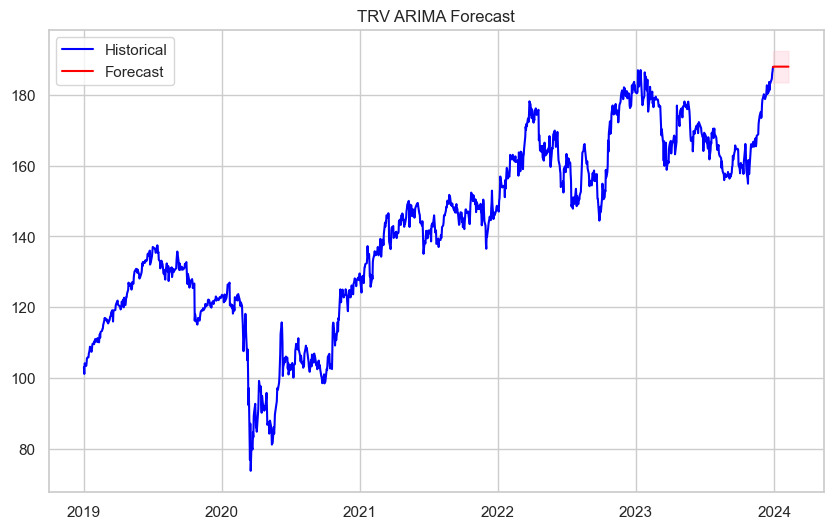

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# List of tickers
insurance_tickers = ["AIG", "MET", "PRU", "ALL", "TRV"]
p_values = [6, 7, 7, 6, 1]  # Provided p-values
q_values = [6, 7, 7, 6, 1]  # Provided q-values
d = 1  # Assuming differencing of 1
forecast_steps = 30  # Number of steps to forecast

# Iterate over each ticker
for i, ticker in enumerate(insurance_tickers):
    try:
        # Fetch the data for the ticker
        ma_data = stock_data[ticker].dropna()
        
        # Check if data is stationary, if not apply differencing
        ma_data_diff = ma_data.diff().dropna()

        diff_train_len = int(len(ma_data_diff)*0.85)
        diff_train = ma_data_diff[:diff_train_len]
        diff_test = ma_data_diff[diff_train_len:]

        
        # Fit ARIMA model
        print(f"Fitting ARIMA({p_values[i]},{d},{q_values[i]}) for {ticker}...")
        model = ARIMA(diff_train, order=(p_values[i], d, q_values[i]))
        model_fit = model.fit()
        
        start = len(diff_train)
        end = len(diff_train) + len(diff_test) - 1

        ma_pred = model_fit.predict(start, end)
        ma_pred.index = diff_test.index

        plt.figure(figsize=(10, 8))
        plt.title('ARIMA Predictions')
        plt.plot(diff_train, label='Train')
        plt.plot(diff_test, label='Test')
        plt.plot(ma_pred, label='Predictions')
        plt.xlabel('Date')
        plt.legend()
        plt.show()


        mae_ma = mean_absolute_error(diff_test, ma_pred)
        mse_ma = mean_squared_error(diff_test, ma_pred)
        rmse_ma = np.sqrt(mean_squared_error(diff_test, ma_pred))

        ma_perf = {'mae_ma': mae_ma, 'mse_ma': mse_ma,'rmse_ma': rmse_ma}
        ma_perf = pd.DataFrame([ma_perf])
        print(f'parameters for {ticker}', ma_perf)

        # Forecast future values
        forecast = model_fit.get_forecast(steps=forecast_steps)
        forecast_mean = forecast.predicted_mean
        forecast_conf_int = forecast.conf_int()

        # Plot historical and forecasted data
        plt.figure(figsize=(10, 6))
        plt.plot(ma_data.index, ma_data, label="Historical", color="blue")
        plt.plot(
            pd.date_range(ma_data.index[-1], periods=forecast_steps, freq="B"),
            forecast_mean + ma_data.iloc[-1],  # Revert differencing
            label="Forecast", color="red"
        )
        plt.fill_between(
            pd.date_range(ma_data.index[-1], periods=forecast_steps, freq="B"),
            forecast_conf_int.iloc[:, 0] + ma_data.iloc[-1],  # Lower bound
            forecast_conf_int.iloc[:, 1] + ma_data.iloc[-1],  # Upper bound
            color="pink", alpha=0.3
        )
        plt.title(f"{ticker} ARIMA Forecast")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error processing {ticker}: {e}")


Simulating for AIG...


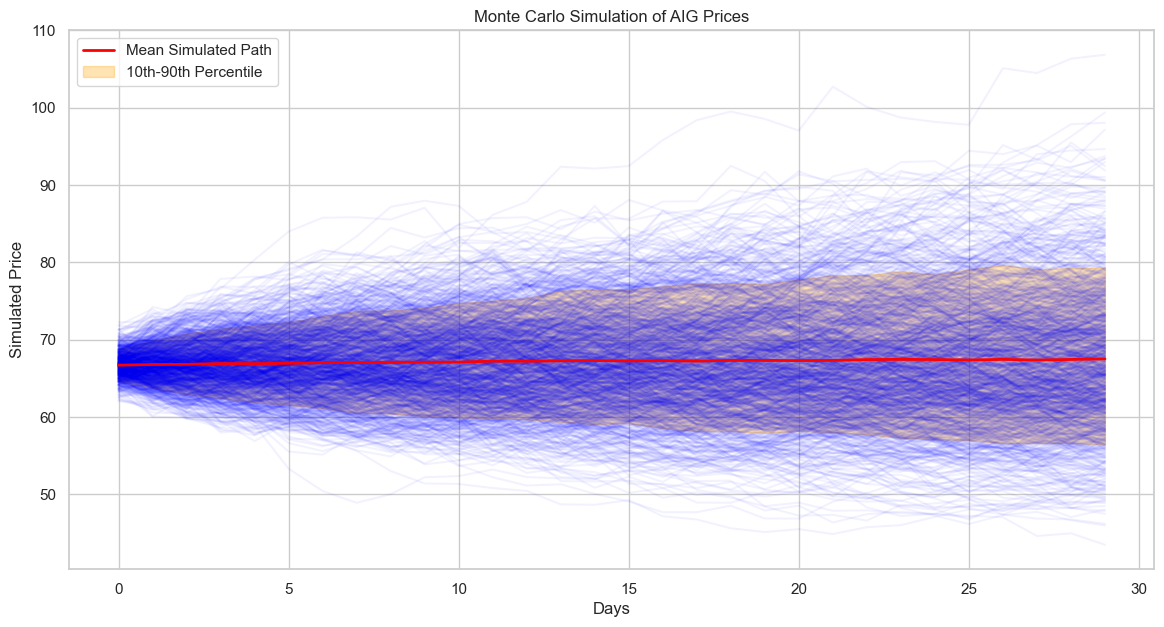

Simulating for MET...


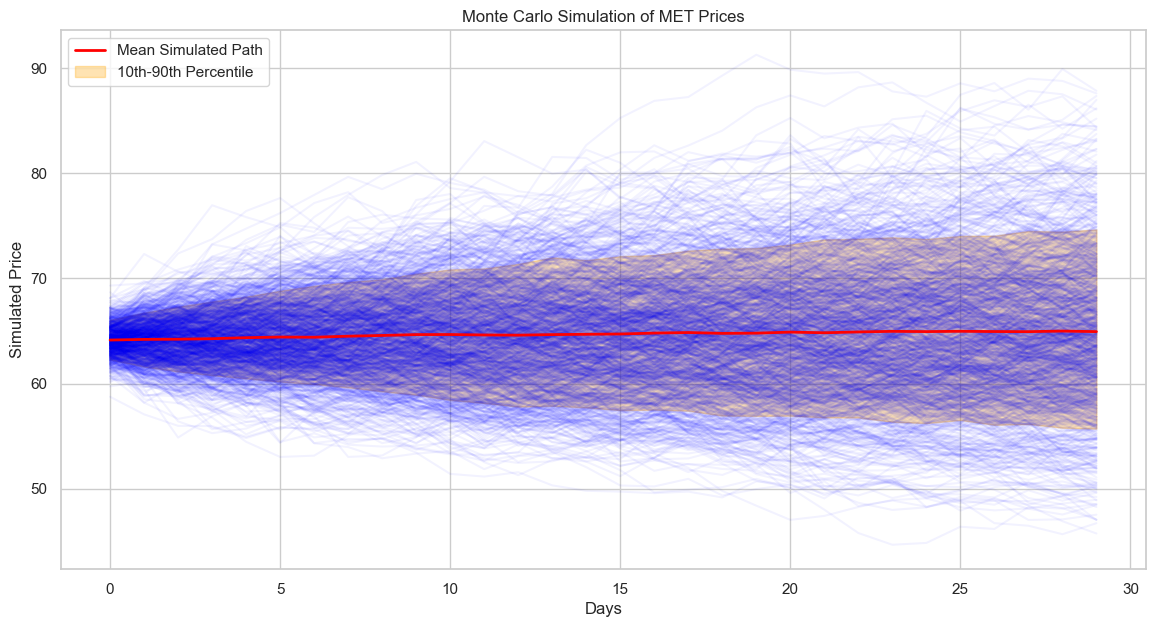

Simulating for PRU...


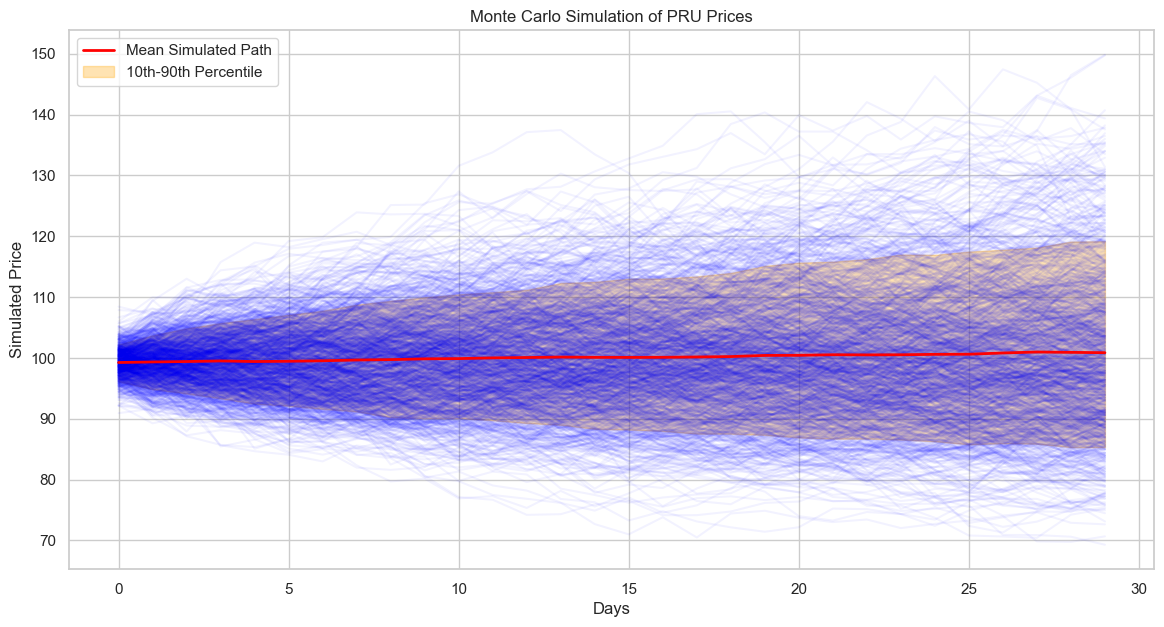

Simulating for ALL...


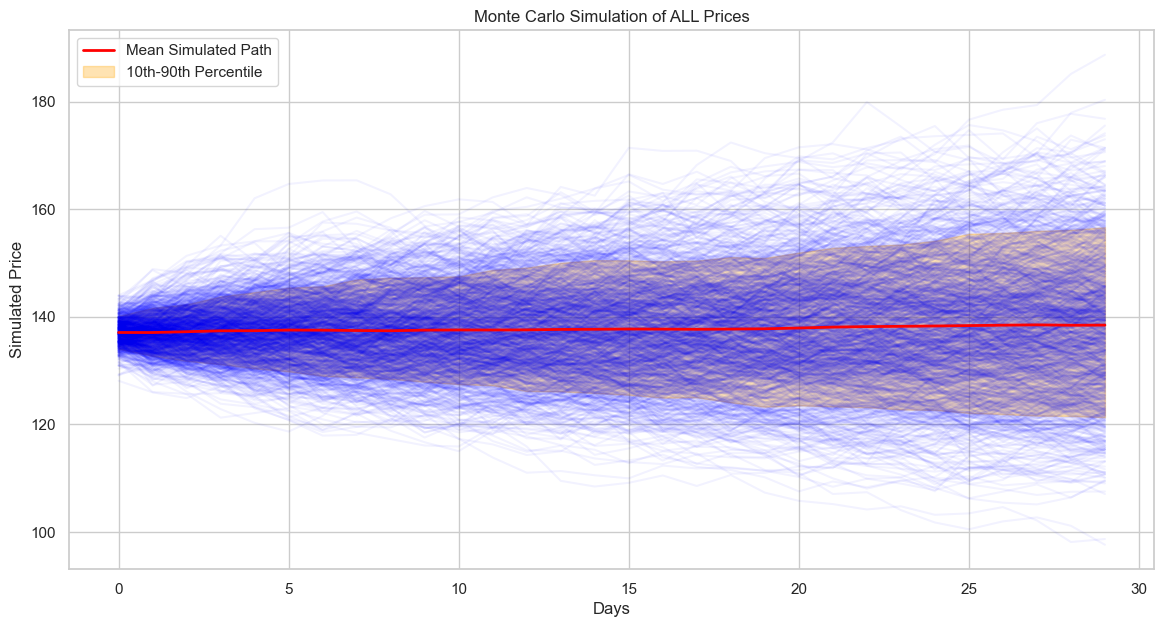

Simulating for TRV...


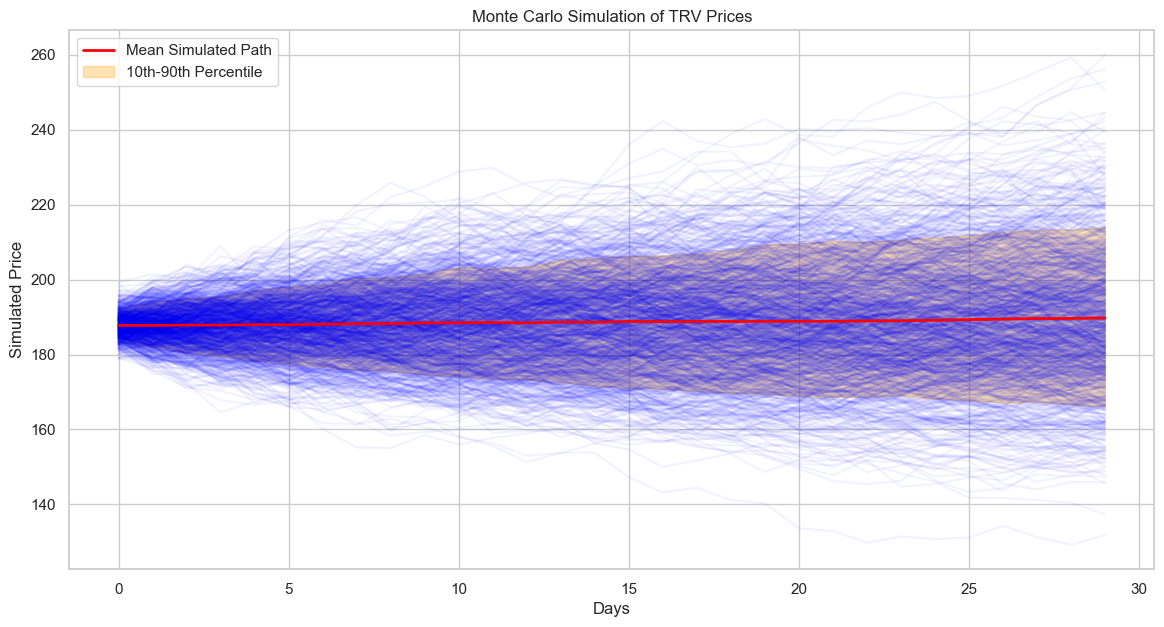

In [190]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Monte Carlo simulation
simulations = 1000
forecast_days = 30

for ticker in insurance_tickers:
    try:
        print(f"Simulating for {ticker}...")
        
        # Initialize array to store simulated prices
        simulated_prices = np.zeros((forecast_days, simulations))
        
        # Get the last price and daily volatility for the ticker
        last_price = stock_data[ticker].iloc[-1]
        daily_volatility = daily_returns[ticker].std()
        
        # Perform simulations
        for sim in range(simulations):
            # Generate random walks with normal distribution
            simulated_prices[:, sim] = last_price * np.exp(np.cumsum(
                np.random.normal(0, daily_volatility, forecast_days)
            ))
        
        # Calculate mean and percentiles for visualization
        mean_price = simulated_prices.mean(axis=1)
        lower_percentile = np.percentile(simulated_prices, 10, axis=1)  # 10th percentile
        upper_percentile = np.percentile(simulated_prices, 90, axis=1)  # 90th percentile
        
        # Plot simulated price paths
        plt.figure(figsize=(14, 7))
        plt.plot(simulated_prices, alpha=0.05, color="blue")  # Individual paths
        plt.plot(mean_price, color="red", label="Mean Simulated Path", linewidth=2)  # Mean path
        plt.fill_between(range(forecast_days), lower_percentile, upper_percentile, 
                         color="orange", alpha=0.3, label="10th-90th Percentile")  # Confidence interval
        plt.title(f"Monte Carlo Simulation of {ticker} Prices")
        plt.xlabel("Days")
        plt.ylabel("Simulated Price")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    except Exception as e:
        print(f"Error processing {ticker}: {e}")



AIG
Simulation Path: Price paths show a moderate variance, reflecting potential price stability.
Confidence Interval: The 10th-90th percentile shows a relatively narrow band, suggesting constrained price swings within the forecast period.
Mean Price Path: Indicates steady growth with minor volatility.

MET
Simulation Path: Consistent price simulations with low deviation from the mean path.
Confidence Interval: Predictable range with moderate uncertainty over 30 days.
Mean Price Path: Slight upward trend, reflecting possible gradual growth.

PRU
Simulation Path: Much more volatility than AIG and MET.
Confidence Interval: The 10th-90th percentile band is wider, indicating higher uncertainty.
Mean Price Path: Follows the current growth.

ALL
Simulation Path: The price paths are moderately variant, indicating a stable performance.
Confidence Interval: The 10th-90th percentile indicates possible mild fluctuations in prices.
Mean Price Path: The path is steady and upward sloping, which means stability.

TRV
Simulation Path: Slightly more volatile compared to the rest of the companies.
Confidence Interval: A wider range of possible simulated outcomes provides evidence of increased risk.
Mean Price Path: This also shows a continued upward trend but with increased volatility.

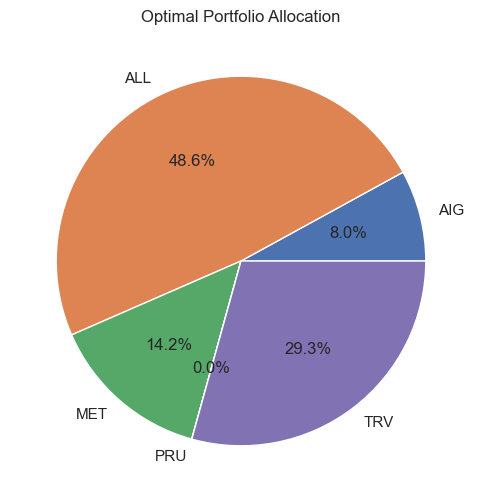

In [225]:
# Initialize portfolio object and calculate statistics
port = rp.Portfolio(returns=daily_returns)
port.assets_stats(method_mu="hist", method_cov="hist")

# Perform portfolio optimization to maximize Sharpe ratio
weights = port.optimization(model="Classic", rm="MV", obj="Sharpe", hist=True)

# Extract weights as a Pandas Series
weights_series = weights.iloc[:, 0]  # Select the first (and only) column if it's a DataFrame

# Plot portfolio allocation as a pie chart
plt.figure(figsize=(10, 6))
weights_series.plot.pie(
    autopct="%1.1f%%",
    title="Optimal Portfolio Allocation",
    legend=False
)
plt.ylabel("")  # Remove y-axis label for cleaner appearance
plt.show()

Portfolio Allocation:
ALL (48.6%):

Dominates the portfolio with nearly half the allocation.
Likely reflects its balance of returns and lower risk based on prior Sharpe ratio and volatility analysis.
TRV (29.3%):

The significant allocation indicates a strong performance-to-risk tradeoff.
The allocation highlights its resilience and moderate volatility.
MET (14.2%):

Moderate allocation, showcasing a reliable risk-return profile.
Demonstrates alignment with medium-risk portfolio strategies.
AIG (8.0%):

Smaller allocation possibly due to higher market risk or less attractive Sharpe ratio compared to ALL and TRV.
PRU (0.0%):

Excluded from the portfolio, suggesting suboptimal performance or unfavorable risk-adjusted returns.
This allocation represents a portfolio optimized to maximize the Sharpe ratio, emphasizing risk-adjusted returns and efficient diversification.

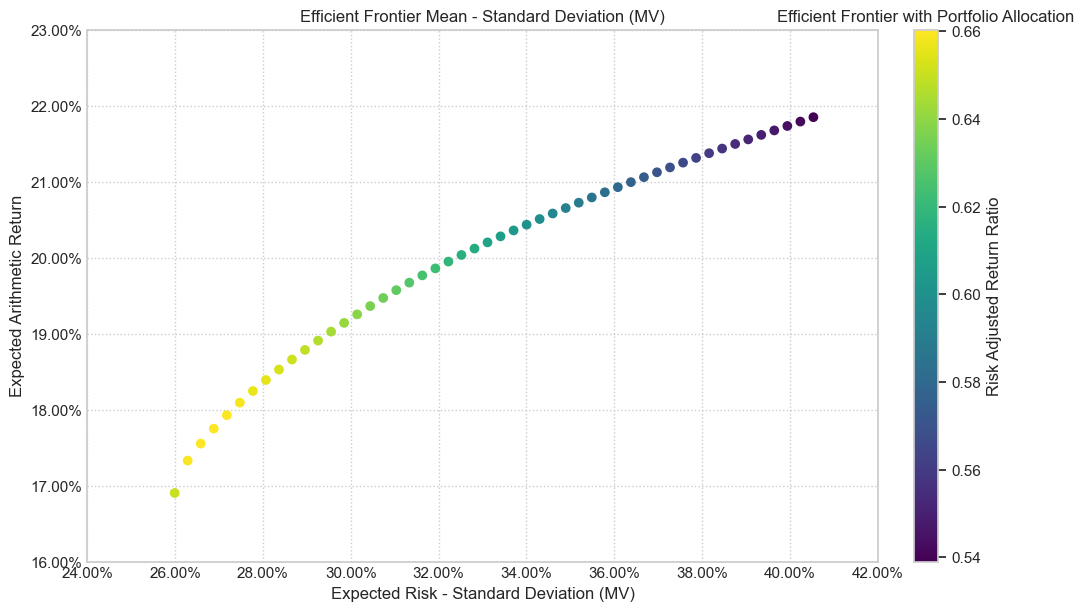

In [227]:
# Generate efficient frontier data
frontier = port.efficient_frontier(model="Classic", rm="MV", points=50)

# Plot the efficient frontier
rp.plot_frontier(
    w_frontier=frontier, 
    mu=port.mu, 
    cov=port.cov, 
    returns=daily_returns, 
    rm="MV", 
    rf=0,  # Risk-free rate, can be set to risk_free_rate
    alpha=0.05,  # Significance level for CVaR (if applicable)
    cmap="viridis"
)
plt.title("Efficient Frontier with Portfolio Allocation")
plt.show()


Risk-Return Tradeoff:

This curve depicts the classic risk-return tradeoff, where with an increase in the risk, that is, standard deviation, the expected return goes up.
This curve may be used by investors to determine their risk tolerance and choose a portfolio that lies on the frontier.

Sharpe Ratio Gradient:

The color gradient outlines portfolios with higher risk-adjusted returns (brighter points). These are the portfolios most efficient in terms of maximizing return for a unit of risk.
The highest Sharpe Ratio portfolios are roughly in the middle of the curve, where the tradeoff is optimized.

Diversification:


The upward-sloping shape of the efficient frontier shows the benefits of diversification; it achieves higher returns for the same risk compared to individual assets or suboptimal portfolios.

Decision Implications:

Risk-Averse Investors: May prefer portfolios on the lower-left section of the frontier with lower risk and moderate returns.
Risk tolerant investors may choose portfolios lying at the top right of the curve, with higher return and risk expectations.

## Conclusion

Volatility and Risk Analysis
AIG and MET exhibited higher volatility, making them suitable for aggressive investment strategies, while TRV displayed lower volatility, ideal for risk-averse investors.
Volatility spikes during 2020 highlighted significant market sensitivity to macroeconomic shocks.

Impact of Economic Trends
All stocks experienced recovery trends post-2020 crash, with TRV and ALL demonstrating resilience.
Long-term growth trajectories reflect alignment with industry benchmarks.

CAPM Analysis
AIG and MET are undervalued according to the SML, promising more than expected returns for their beta.
TRV and PRU show overvaluation or inefficiencies in the market and should be invested in with care.

Risk-Adjusted Returns
Sharpe and Treynor ratios confirm ALL as the most efficient in risk-adjusted performance.
High Sharpe ratios in AIG and MET indicate good returns in relation to their risks.

Portfolio Analysis Using Modern Portfolio Theory (MPT)
The efficient frontier analysis underlines the benefits of diversification by balancing high-beta stocks with stable performers.
Aggressive portfolio strategies are dominated by AIG and MET, while TRV and ALL provide the supporting defense.


AIG and MET are promising stocks to deliver higher risk-adjusted returns and could be used by investors seeking growth-oriented portfolios. 
TRV and ALL help balance portfolios due to lower volatility, hence offering stability during times of economic turmoil. 
Rebalancing: Periodically review and rebalance such portfolios in line with changeable market dynamics, especially for stocks with high beta. 
Correlation Management: Implement insights from correlation analysis to steer clear of overexposure to strongly correlated stocks to minimize systemic risk. 
Market Hedging: Utilize TRV and ALL as defensive investments, in particular during market downturns, to protect portfolio value.
